# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'grenoble_2019-03-28_1856800.zip'
simgrid_archives = ['../smpi_hpl/grenoble_2019-04-03_1858209.zip']
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[400000, 20000, 100000, 10000, 50000, 200000]


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
        if len(tmp_trace) > nbrow_limit:
            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if mode == 'simgrid':
            installfile = get_yaml(filename, 'info.yaml')['installfile']
            install_options = get_yaml(filename, installfile)
            stochastic_cpu = install_options['stochastic_cpu']
            polynomial_dgemm = install_options['polynomial_dgemm']
            stochastic_network = install_options['stochastic_network']
            cpu = 'stochastic CPU' if stochastic_cpu else 'deterministic CPU'
            dgemm = 'polynomial DGEMM' if polynomial_dgemm else 'linear DGEMM'
            network = 'stochastic network' if stochastic_network else 'deterministic network'
            mode = 'simgrid: %s & %s & %s' % (cpu, dgemm, network)
            tmp_trace['mode'] = mode
            tmp_trace['stochastic_cpu'] = stochastic_cpu
            tmp_trace['polynomial_dgemm'] = polynomial_dgemm
            tmp_trace['stochastic_network'] = stochastic_network
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=400000)
# Mode: reality
	BLAS trace: 151056 lines (removed 6048 lines with null sizes)
	MPI  trace: 192068 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 150529 lines (removed 6084 lines with null sizes)
	MPI  trace: 170990 lines
Removed 512 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
Exp 1 (matrix_size=20000)
# Mode: reality
	BLAS trace:  61945 lines (removed 2672146 lines with null sizes)
	MPI  trace: 103012 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace:  61233 lines (removed 14739 lines with null sizes)
	MPI  trace:  81934 lines
Removed 512 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
Exp 2 (matrix_size=100000)
# Mode: 

duration        end     function   k  kind        m  matrix_size     mode  \
0  0.000000  14.456250  smpi_marker NaN  BLAS      NaN       400000  reality   
1  0.000054  14.456364       idamax NaN  BLAS  50048.0       400000  reality   
2  0.000008  14.456378        dcopy NaN  BLAS    128.0       400000  reality   
3  0.000002  14.456382        dcopy NaN  BLAS    128.0       400000  reality   
4  0.000032  14.472762        dscal NaN  BLAS  50047.0       400000  reality   

   msg_size   n polynomial_dgemm  rank  rank+1     start stochastic_cpu  \
0        -1 NaN              NaN     0       1  14.45625            NaN   
1        -1 NaN              NaN     0       1  14.45631            NaN   
2        -1 NaN              NaN     0       1  14.45637            NaN   
3        -1 NaN              NaN     0       1  14.45638            NaN   
4        -1 NaN              NaN     0       1  14.47273            NaN   

  stochastic_network  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

## HPL result

In [4]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

matrix_size   time
3        10000   0.09
1        20000   0.18
4        50000   0.68
2       100000   2.33
5       200000   8.78
0       400000  32.71

In [5]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    install_options = get_yaml(archive, installfile)
    tmp['stochastic_cpu'] = install_options['stochastic_cpu']
    tmp['polynomial_dgemm'] = install_options['polynomial_dgemm']
    tmp['stochastic_network'] = install_options['stochastic_network']
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time', 'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network']].sort_values(by='matrix_size')

matrix_size   time  stochastic_cpu  polynomial_dgemm  stochastic_network
3        10000   0.06            True              True                True
1        20000   0.15            True              True                True
4        50000   0.65            True              True                True
2       100000   2.18            True              True                True
5       200000   7.85            True              True                True
0       400000  30.15            True              True                True

## Checking the parameters

In [6]:
parameters = read_csv(simgrid_archives[0], 'exp_smpi.csv')
for archive in simgrid_archives:
    assert read_csv(archive, 'exp_smpi.csv').equals(parameters)
parameters

matrix_size  block_size  proc_p  proc_q  pfact  rfact  bcast  depth  swap  \
0       400000         128       8      32      1      2      2      1     0   
1        20000         128       8      32      1      2      2      1     0   
2       100000         128       8      32      1      2      2      1     0   
3        10000         128       8      32      1      2      2      1     0   
4        50000         128       8      32      1      2      2      1     0   
5       200000         128       8      32      1      2      2      1     0   

   mem_align  process_per_node  thread_per_process  dgemm_coefficient  \
0          8                32                   1                 42   
1          8                32                   1                 42   
2          8                32                   1                 42   
3          8                32                   1                 42   
4          8                32                   1                 42   
5          8                32                   1                 42   

   dgemm_intercept  dtrsm_coefficient  dtrsm_intercept  
0               42                 42               42  
1               42                 42               42  
2               42                 42               42  
3               42                 42               42  
4               42                 42               42  
5               42                 42               42

In [7]:
read_csv(reality_archive, 'exp.csv')

matrix_size  block_size  proc_p  proc_q  pfact  rfact  bcast  depth  swap  \
0       400000         128       8      32      1      2      2      1     0   
1        20000         128       8      32      1      2      2      1     0   
2       100000         128       8      32      1      2      2      1     0   
3        10000         128       8      32      1      2      2      1     0   
4        50000         128       8      32      1      2      2      1     0   
5       200000         128       8      32      1      2      2      1     0   

   mem_align  process_per_node  thread_per_process  
0          8                32                   1  
1          8                32                   1  
2          8                32                   1  
3          8                32                   1  
4          8                32                   1  
5          8                32                   1

In [8]:
platforms = set([zipfile.ZipFile(archive).read('dahu.xml').decode('ascii') for archive in simgrid_archives])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460

In [9]:
from IPython.display import display, Markdown
for archive in simgrid_archives:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    installfile_content = zipfile.ZipFile(archive).read(installfile).decode()
    display(Markdown('Archive name: %s' % archive))
    display(Markdown('```yaml\n%s\n```' % installfile_content))

Archive name: ../smpi_hpl/grenoble_2019-04-03_1858209.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
polynomial_dgemm: True
heterogeneous_dgemm: True

```

## Visualizing the trace

In [10]:
def split(df):
    '''
    For reasons I don't fully understand, the "elegant" implementation with list comprehension is *very* inneficient.
    I don't know if there is a more "pythonic" approach than this one, which seems pretty ugly to me but works fine.
    '''
    all_ranks = list(df['rank'].unique())
    all_sizes = list(df['matrix_size'].unique())
    all_modes = list(df['mode'].unique())
    all_kinds = list(df['kind'].unique())
    all_df = []
    for rank in all_ranks:
        tmp_rank = df[df['rank'] == rank]
        for matrix_size in all_sizes:
            tmp_size = tmp_rank[tmp_rank['matrix_size'] == matrix_size]
            for mode in all_modes:
                tmp_mode = tmp_size[tmp_size['mode'] == mode]
                for kind in all_kinds:
                    all_df.append(tmp_mode[tmp_mode['kind'] == kind])
    return all_df

def crop(df):
    kind = list(df['kind'].unique())
    assert len(kind) == 1
    kind = kind[0]
    if kind == 'BLAS':
        func_calls = df[df['function'] == 'smpi_marker']
    else:
        assert kind == 'MPI'
        func_calls = df[df['function'] == 'MPI_Bcast']
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    df = df[(df['start'] > start) & (df['end'] < end)].copy()
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

def crop_all(df):
    df_split = [crop(tmp_df) for tmp_df in split(df)]
    return pandas.concat(df_split)

traces = crop_all(traces)

In [11]:
traces['func'] = traces['function']
traces.loc[~traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

In [12]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = False
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

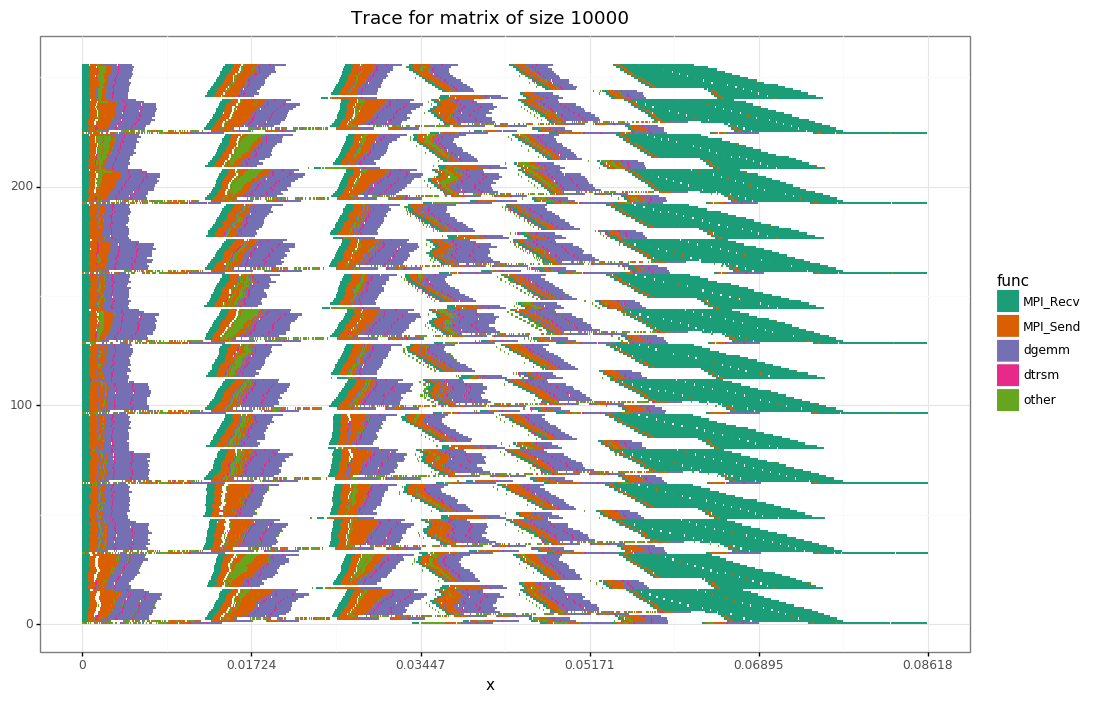

<ggplot: (8794079685149)>


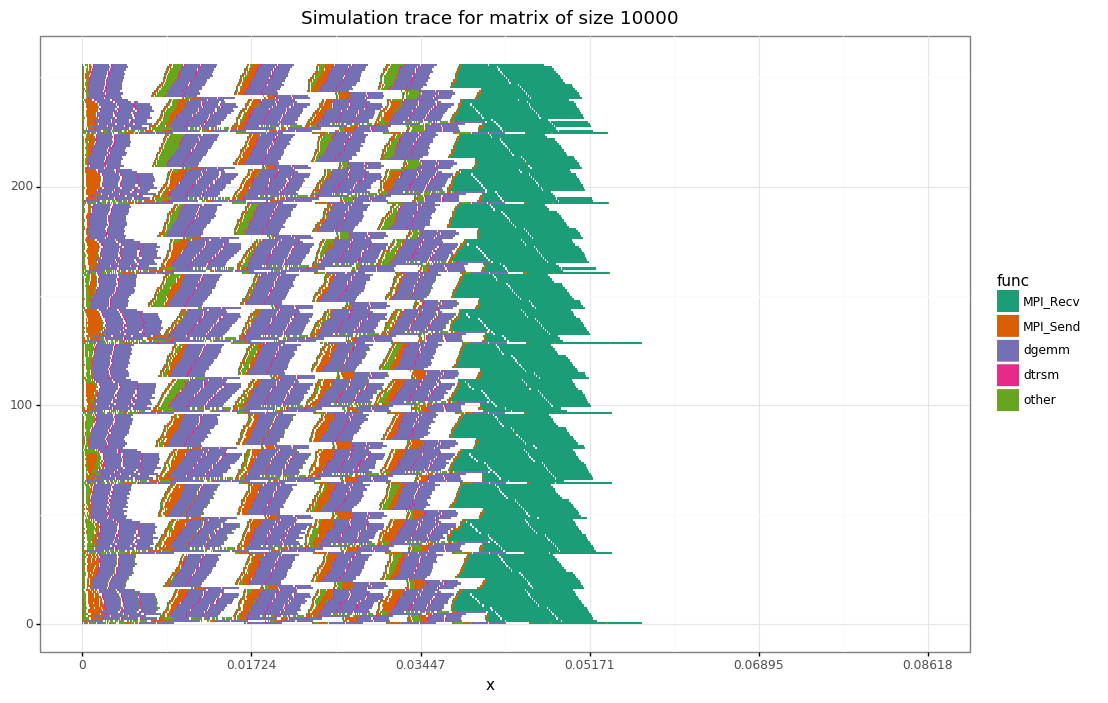

<ggplot: (8794080807032)>


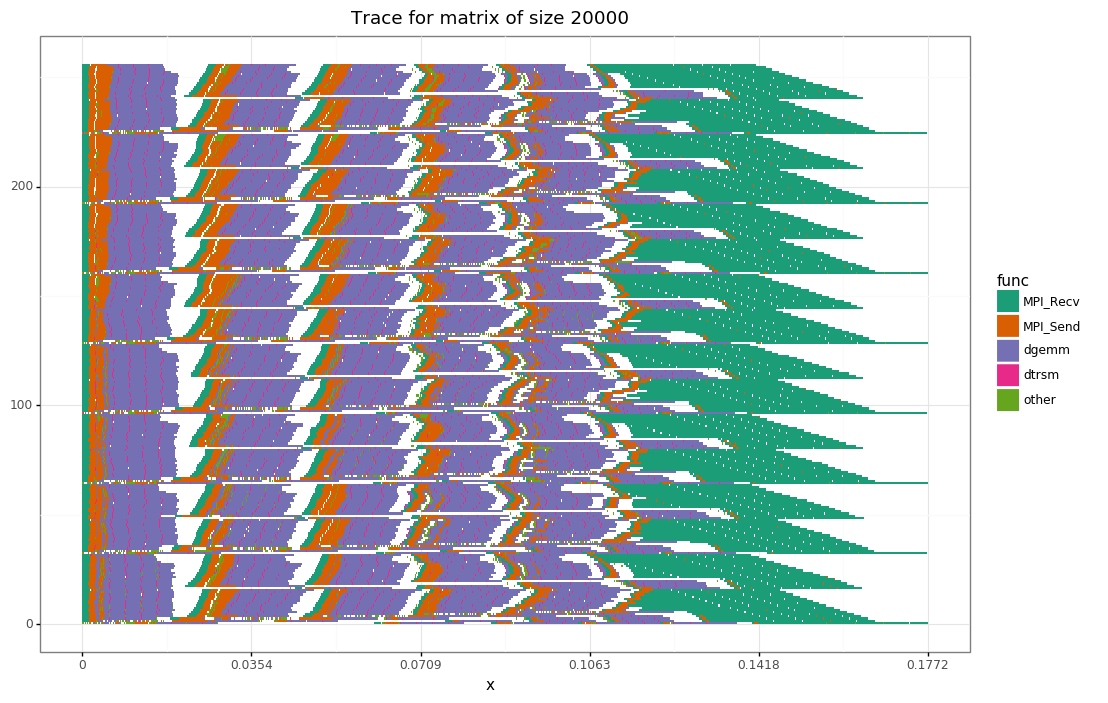

<ggplot: (-9223363242755332359)>


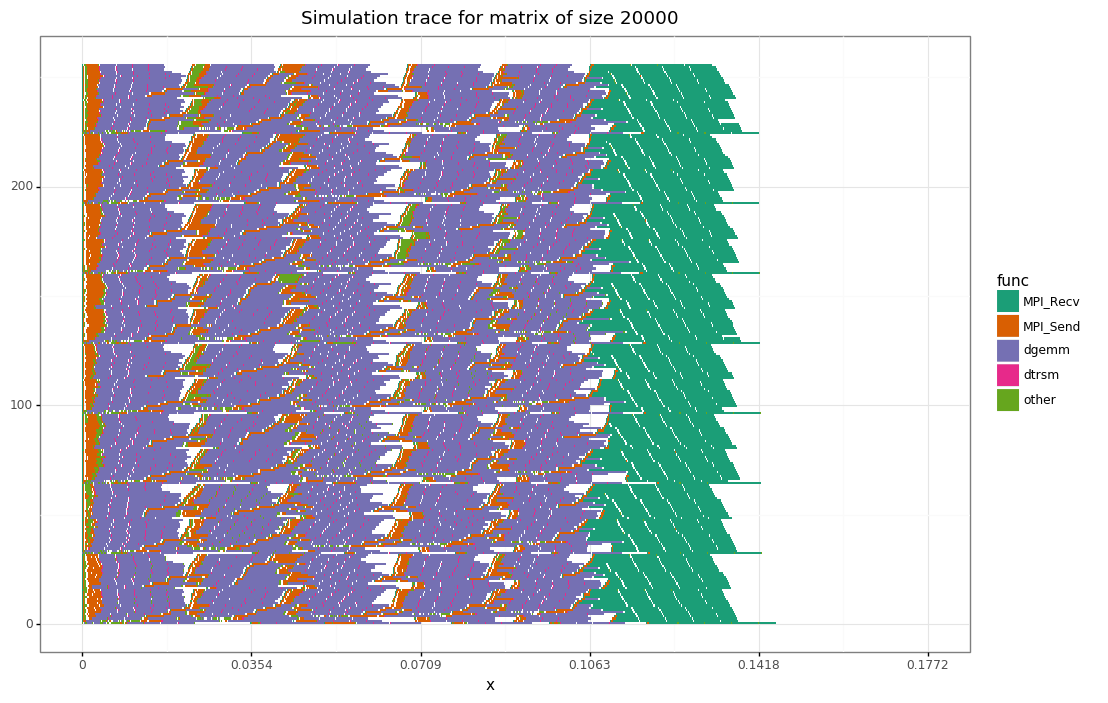

<ggplot: (-9223363242777033682)>


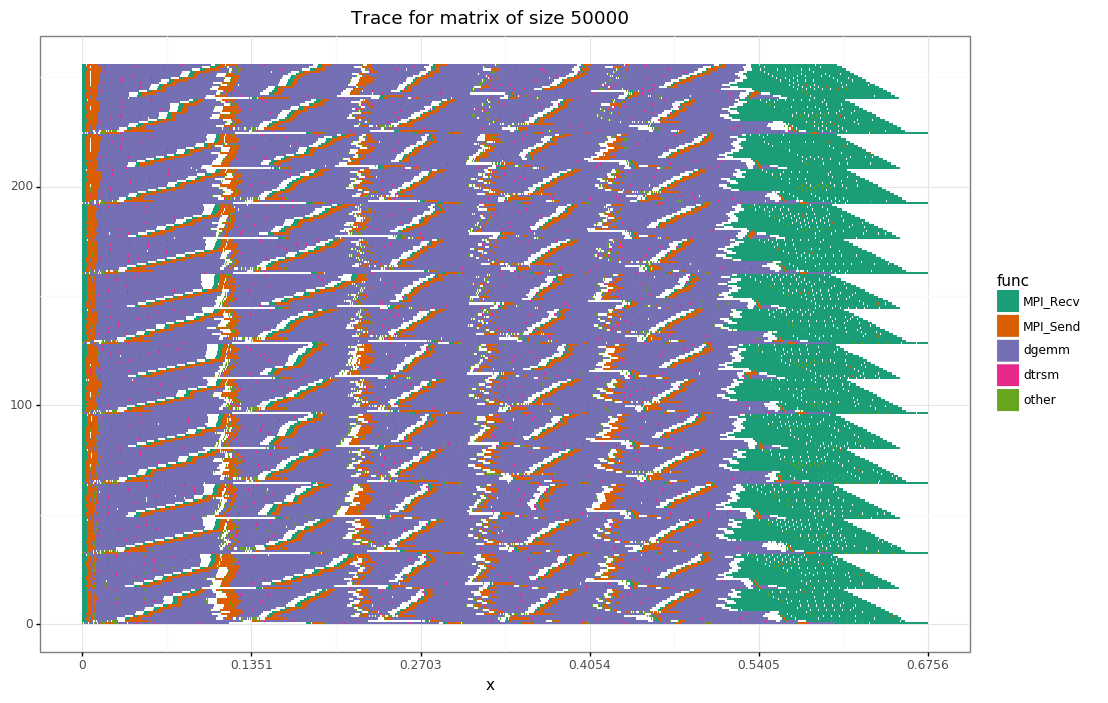

<ggplot: (-9223363242741916093)>


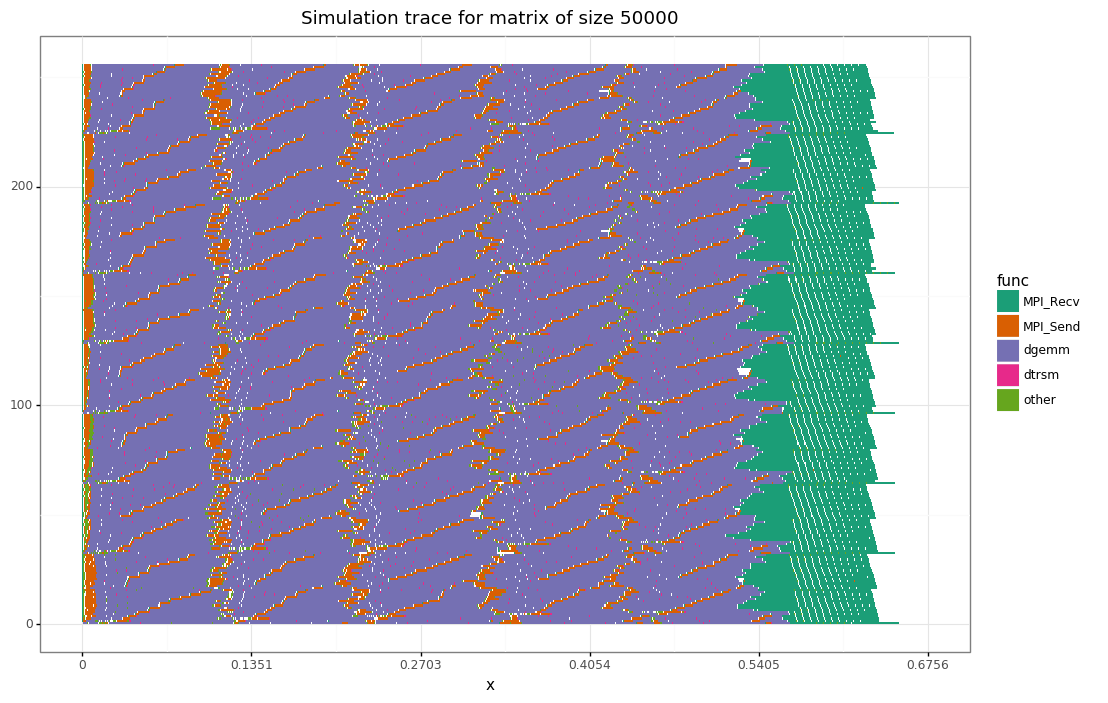

<ggplot: (-9223363242777145561)>


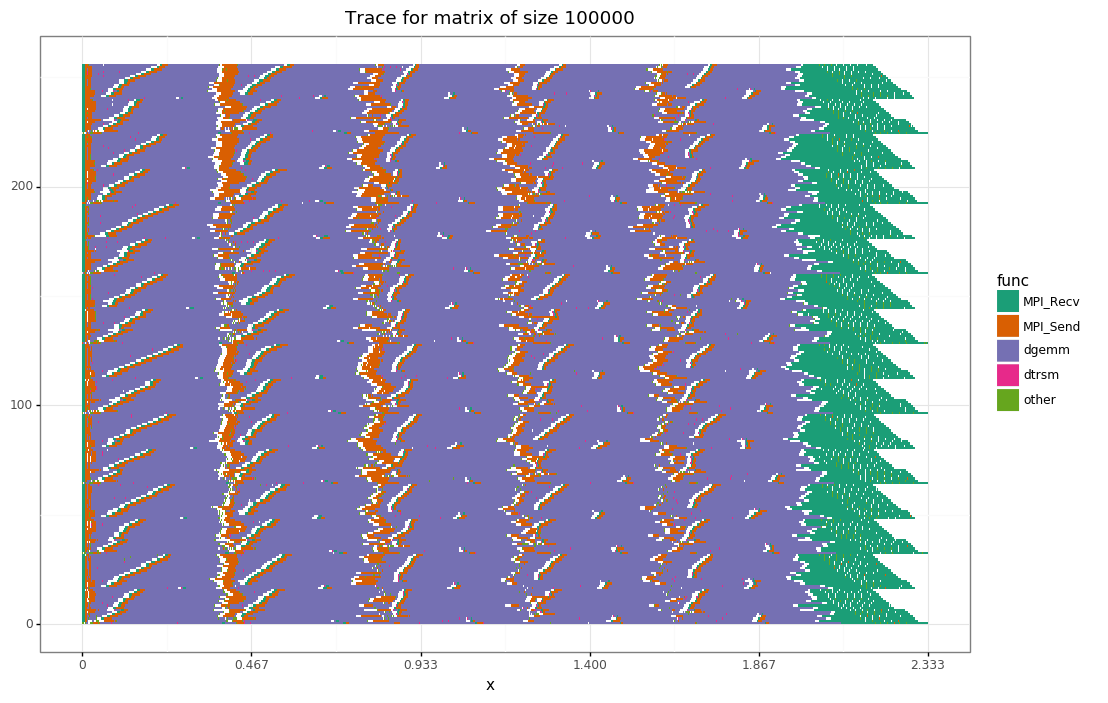

<ggplot: (8794074815857)>


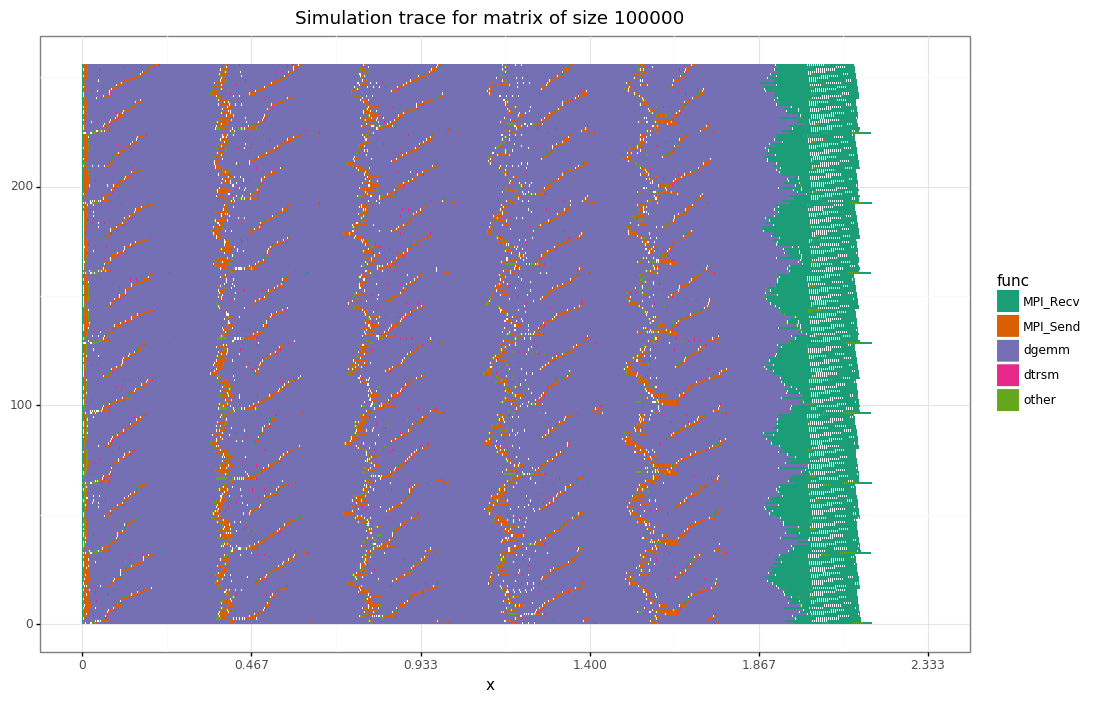

<ggplot: (-9223363242777210722)>


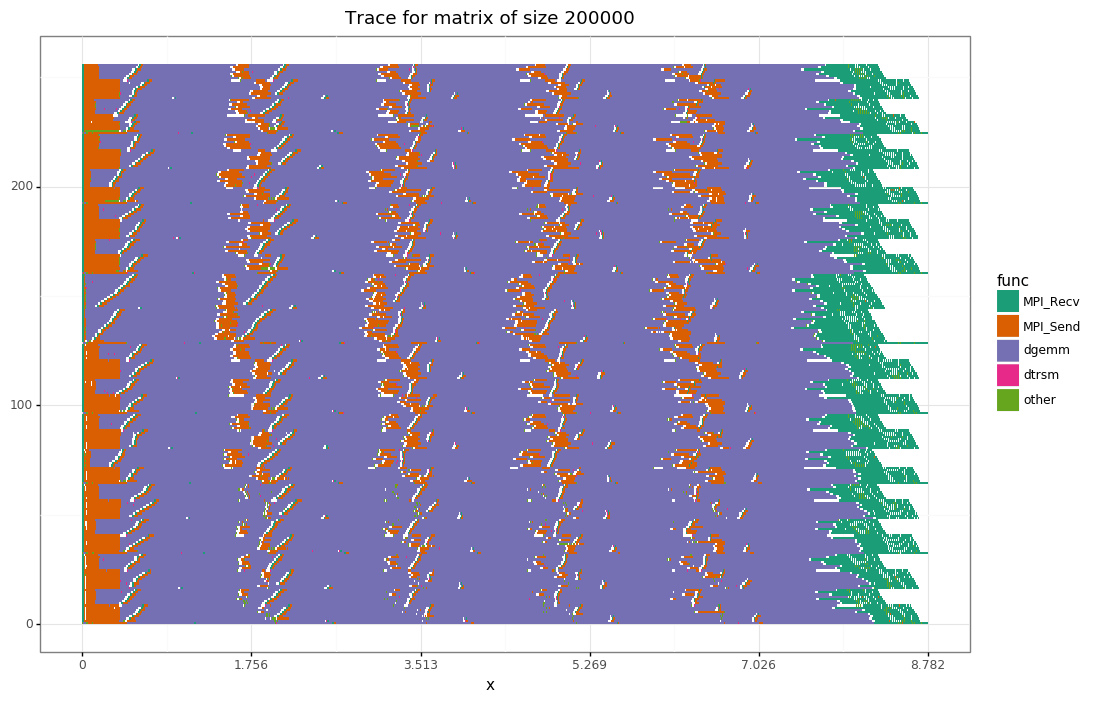

<ggplot: (8794074879061)>


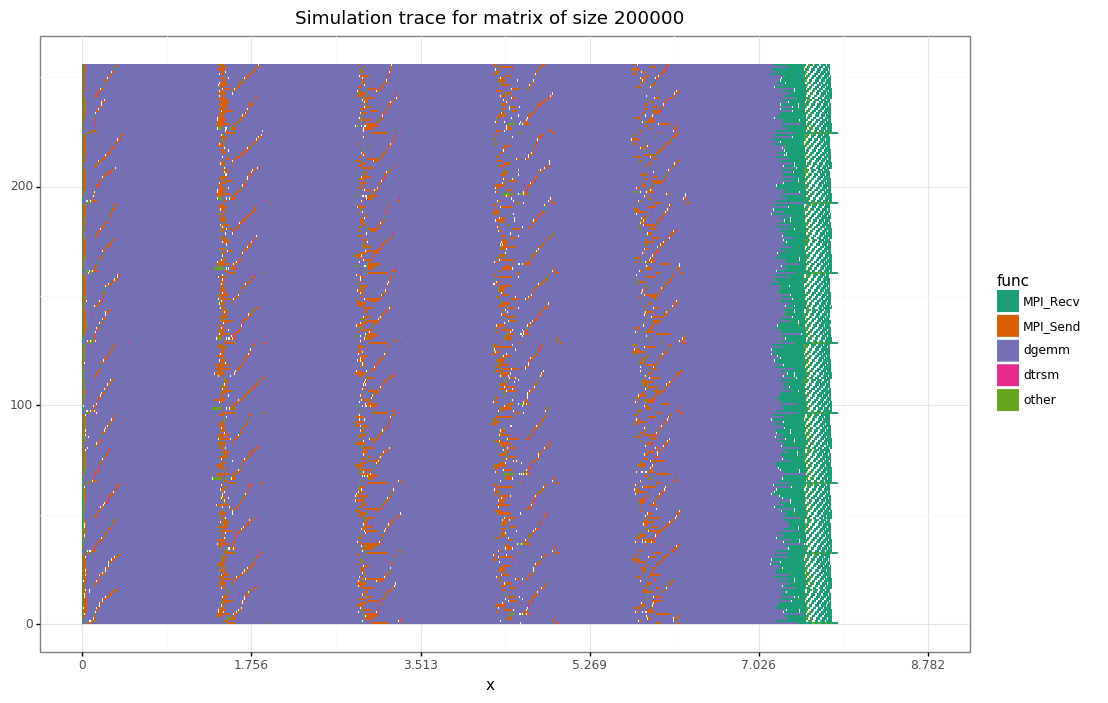

<ggplot: (8794074839567)>


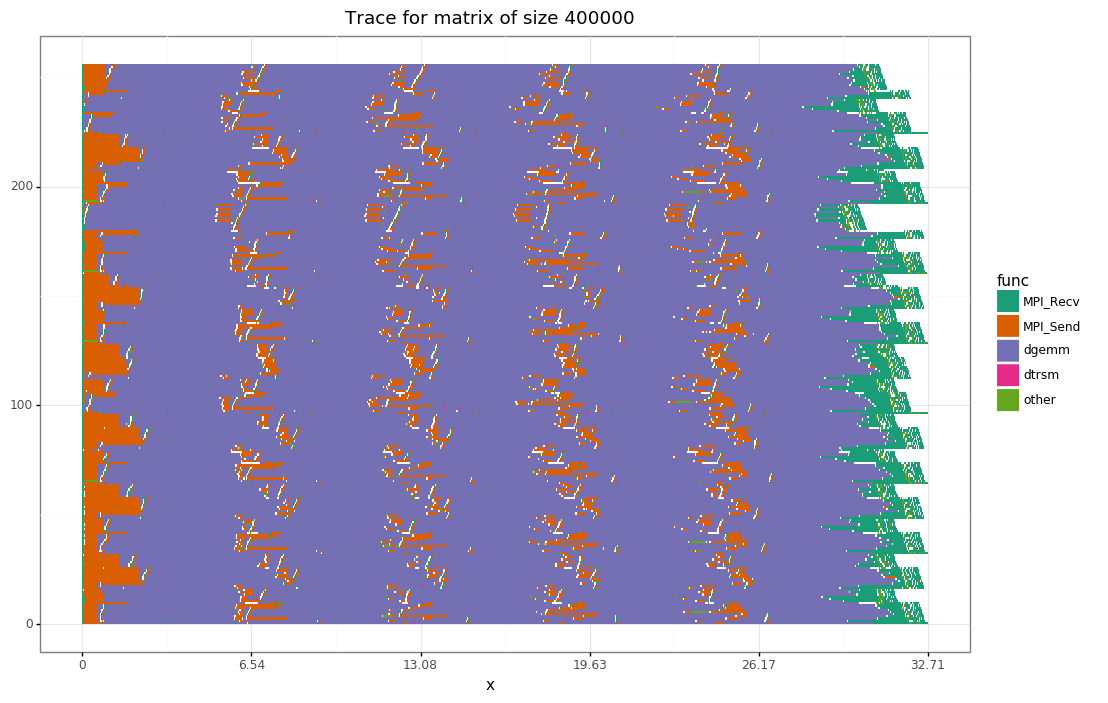

<ggplot: (8794074966413)>


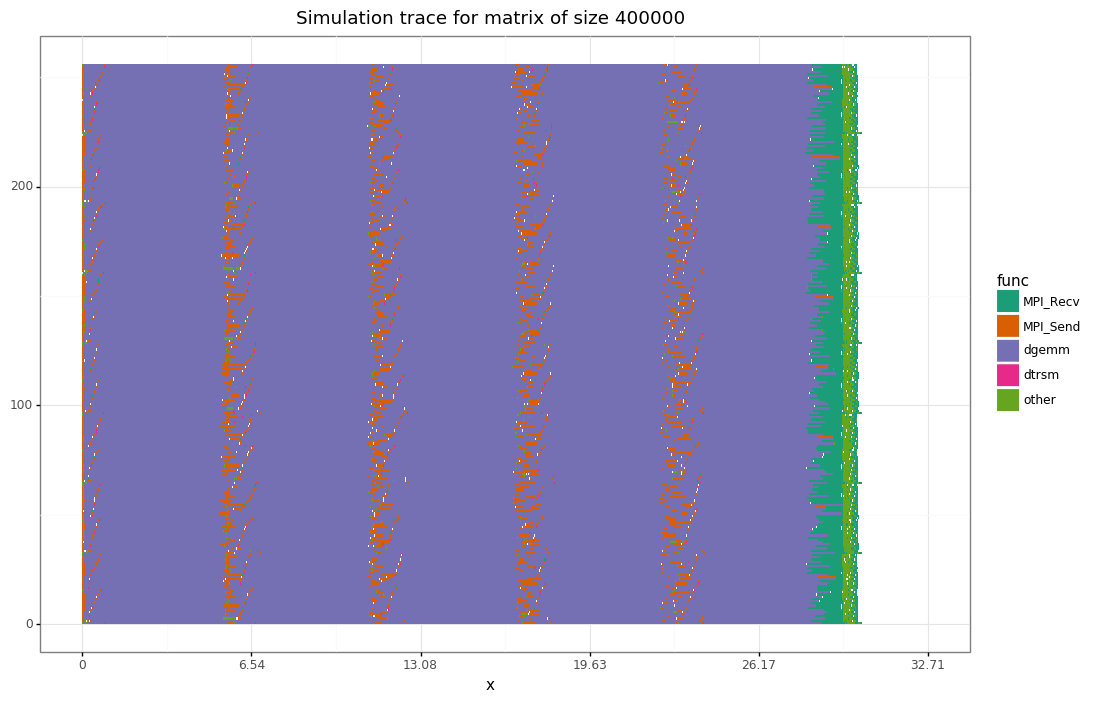

<ggplot: (-9223363242777333174)>


In [13]:
for size in sorted(traces.matrix_size.unique()):
    tmp = traces[(traces['matrix_size'] == size)]
    lines = my_range(tmp.start.min(), tmp.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    print(plot(tmp[tmp['mode'] != 'reality'], lines=lines) + ggtitle('Simulation trace for matrix of size %d' % size))

## Plotting the total time spent in each function

In [14]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'mode', 'start', 'end', 'duration', 'matrix_size']]
    df = df.groupby(['rank', 'mode', 'matrix_size']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='factor(mode)')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    plot = plot + facet_wrap('matrix_size', scales='free') + theme(subplots_adjust={'wspace':0.20})
    print(plot)
####################################################
    return  # not plotting the differencep plot
    modes = list(df['mode'].unique())
    if len(modes) != 2:
        return
    df1 = df[df['mode'] == modes[0]]
    df2 = df[df['mode'] == modes[1]]
    df = df1.set_index('rank').join(df2.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

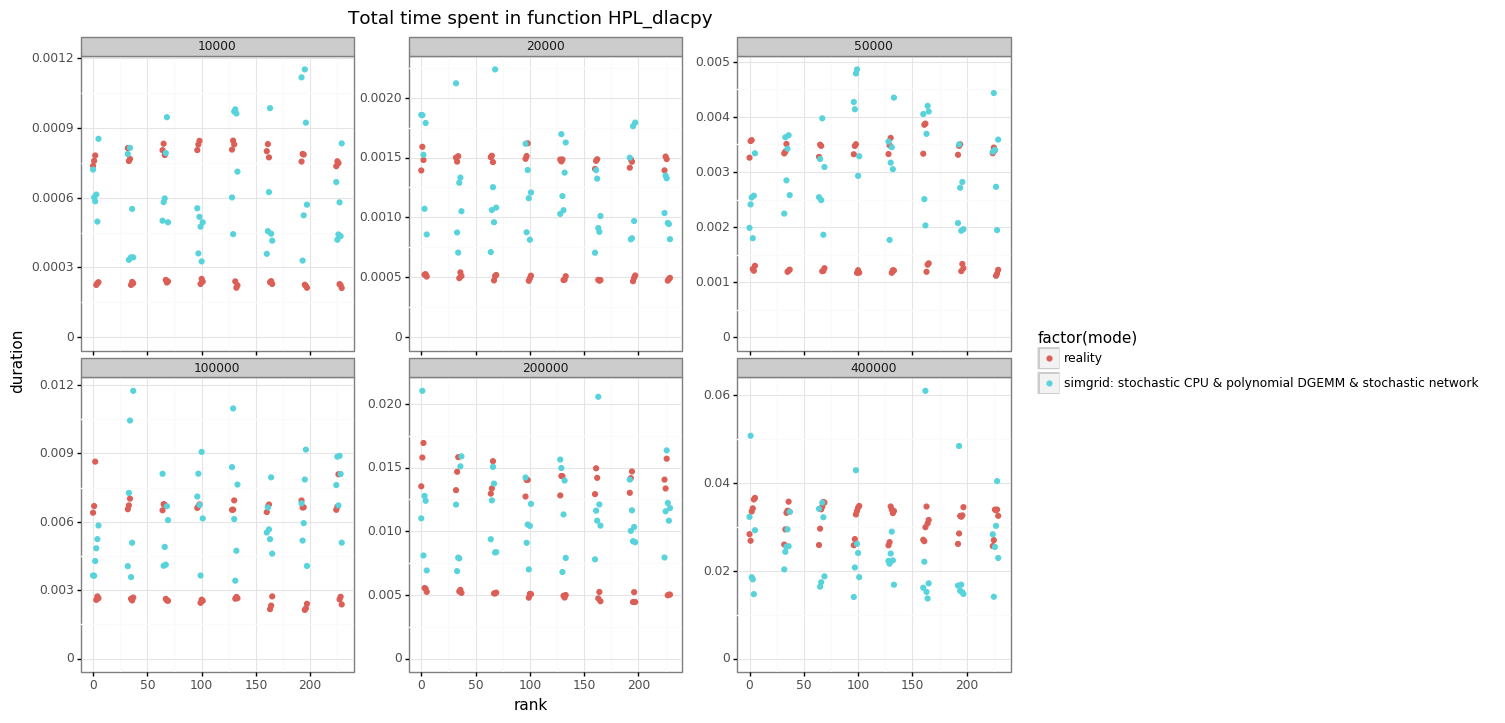

<ggplot: (-9223363242773444394)>


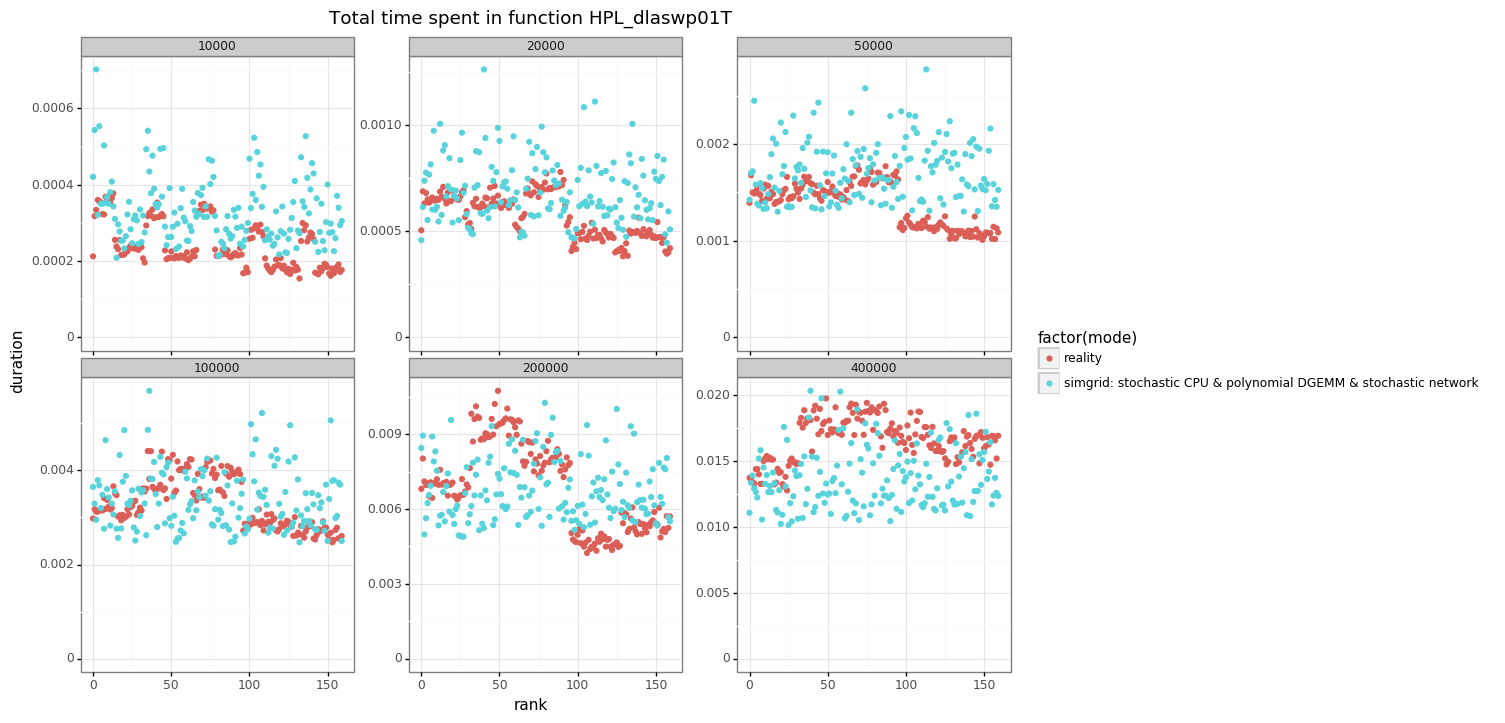

<ggplot: (-9223363242779178941)>


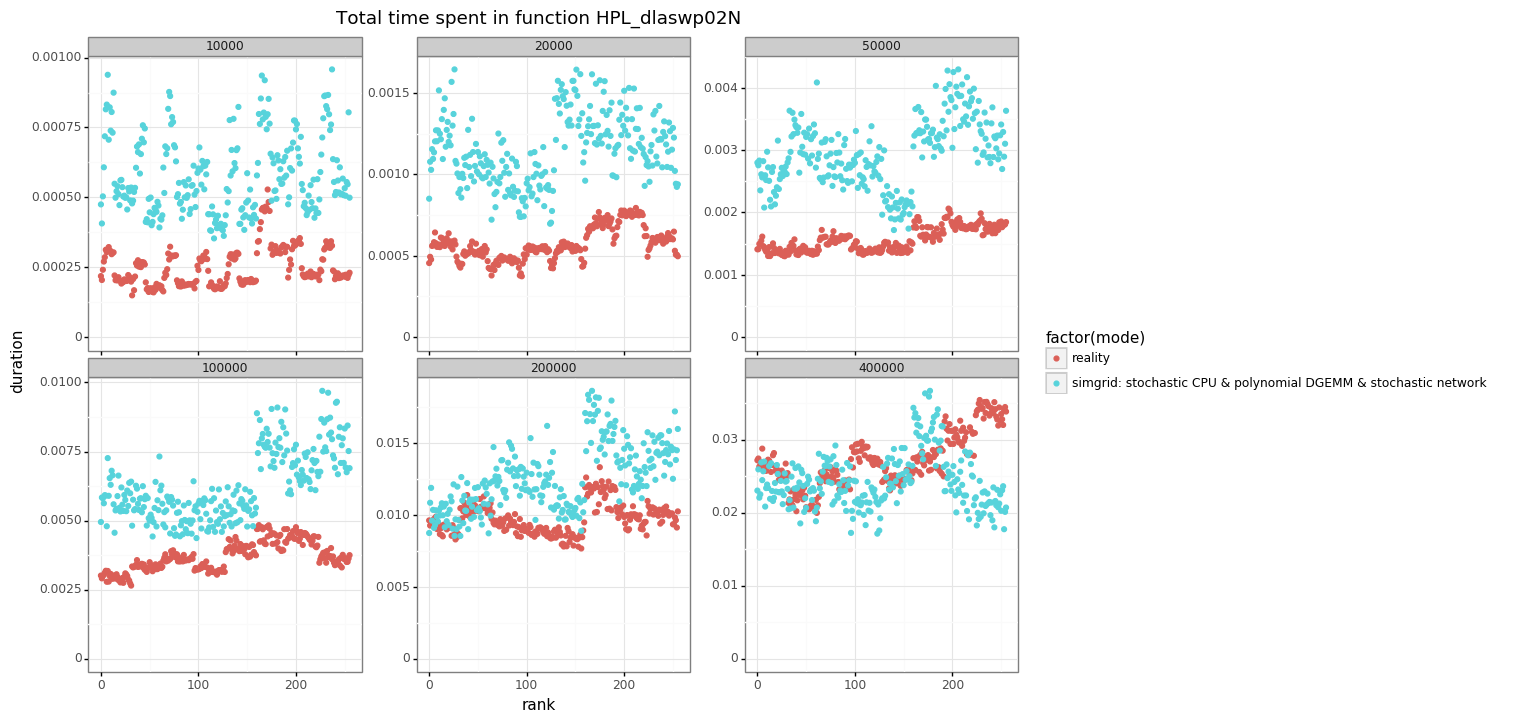

<ggplot: (8794075136071)>


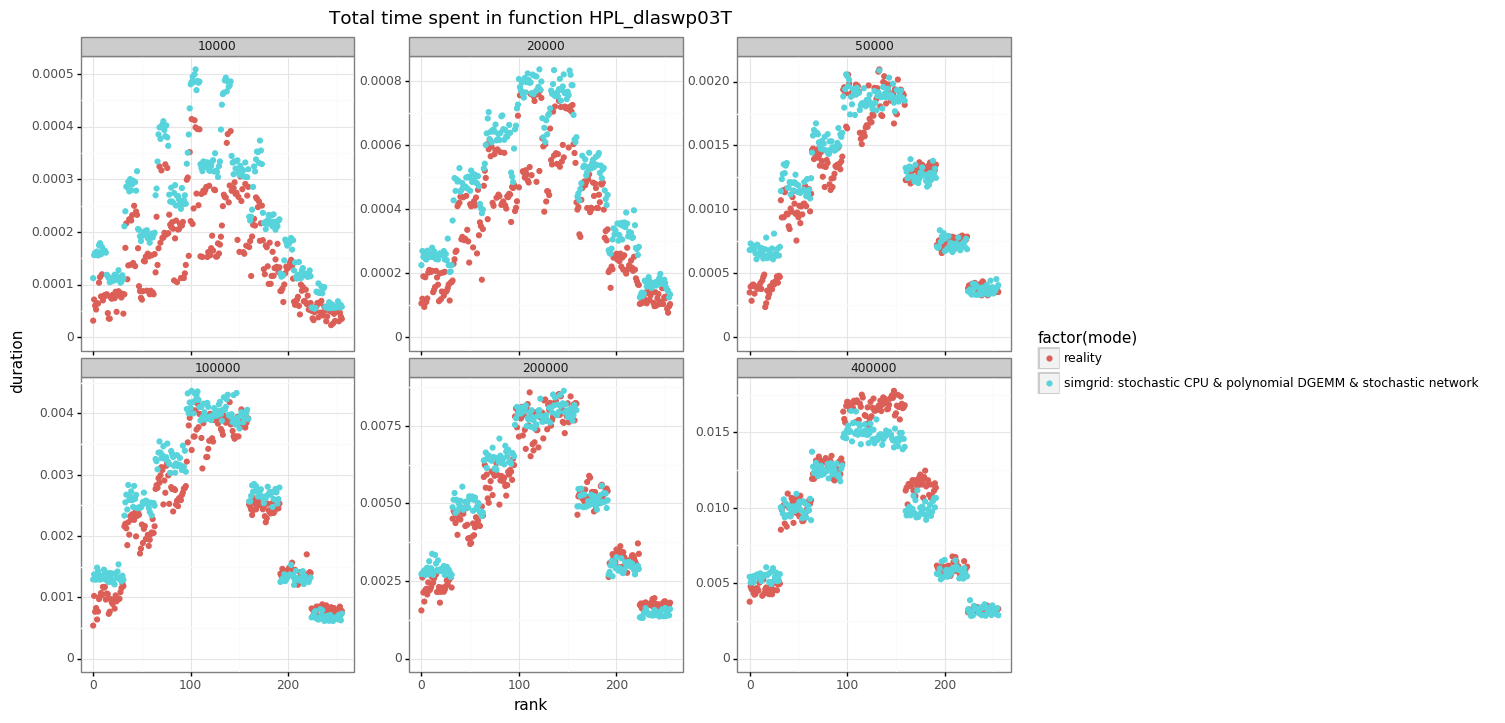

<ggplot: (8794076745806)>


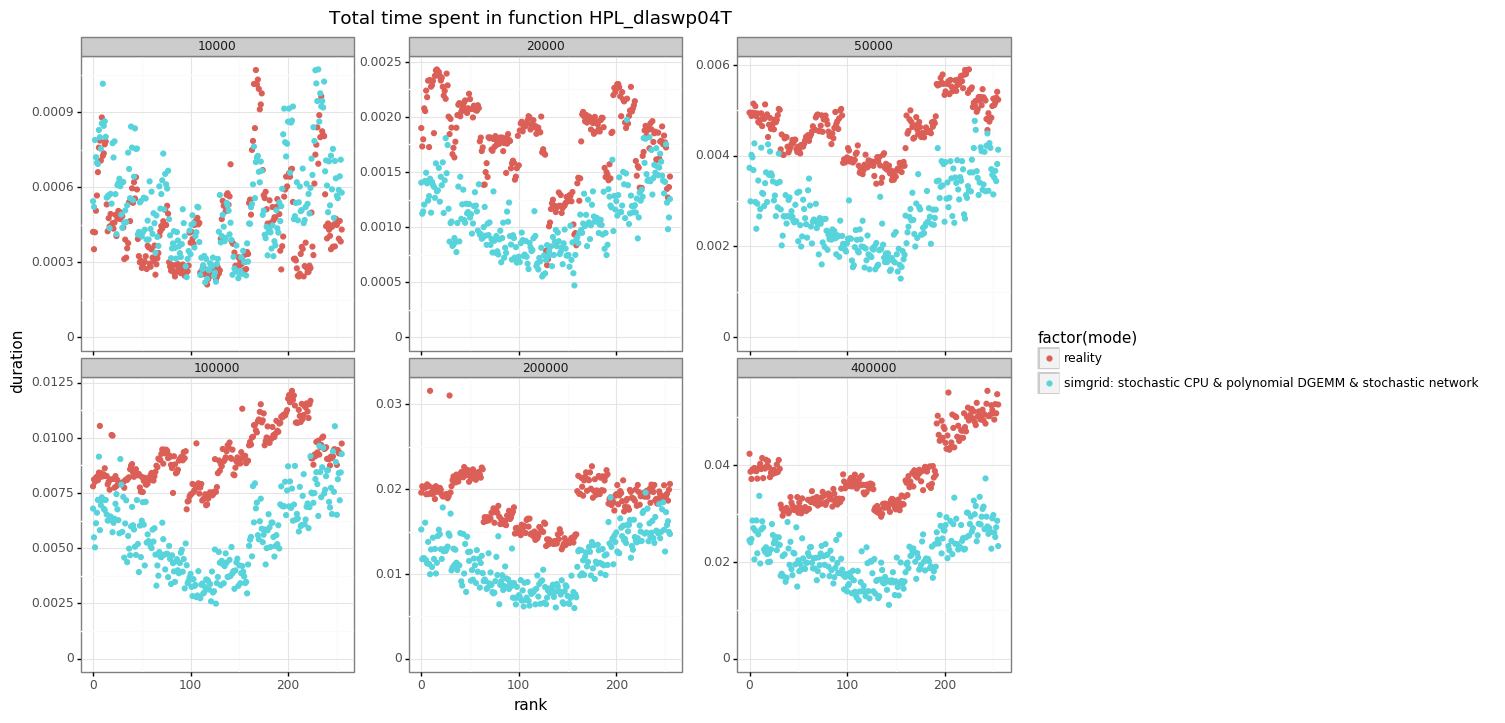

<ggplot: (8794075268328)>


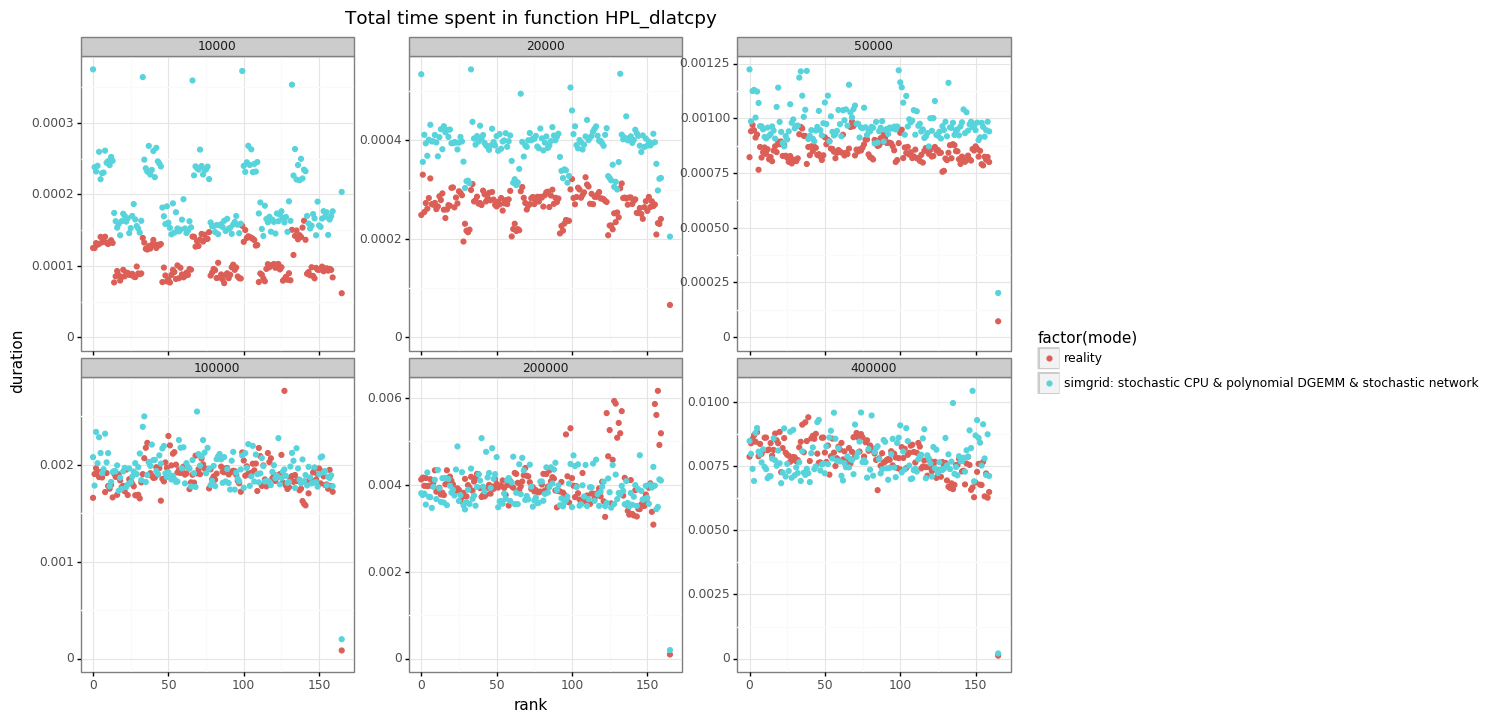

<ggplot: (8794076186828)>


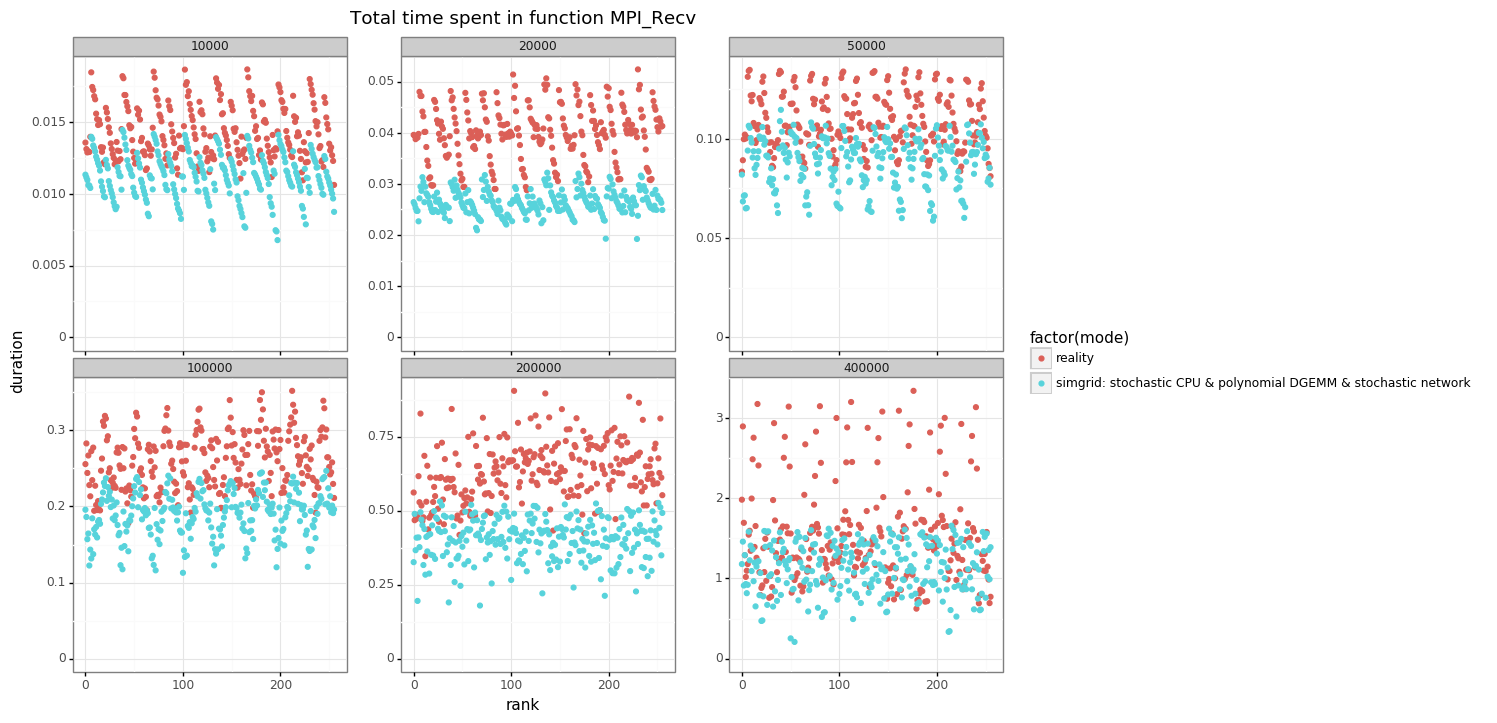

<ggplot: (8794075425207)>


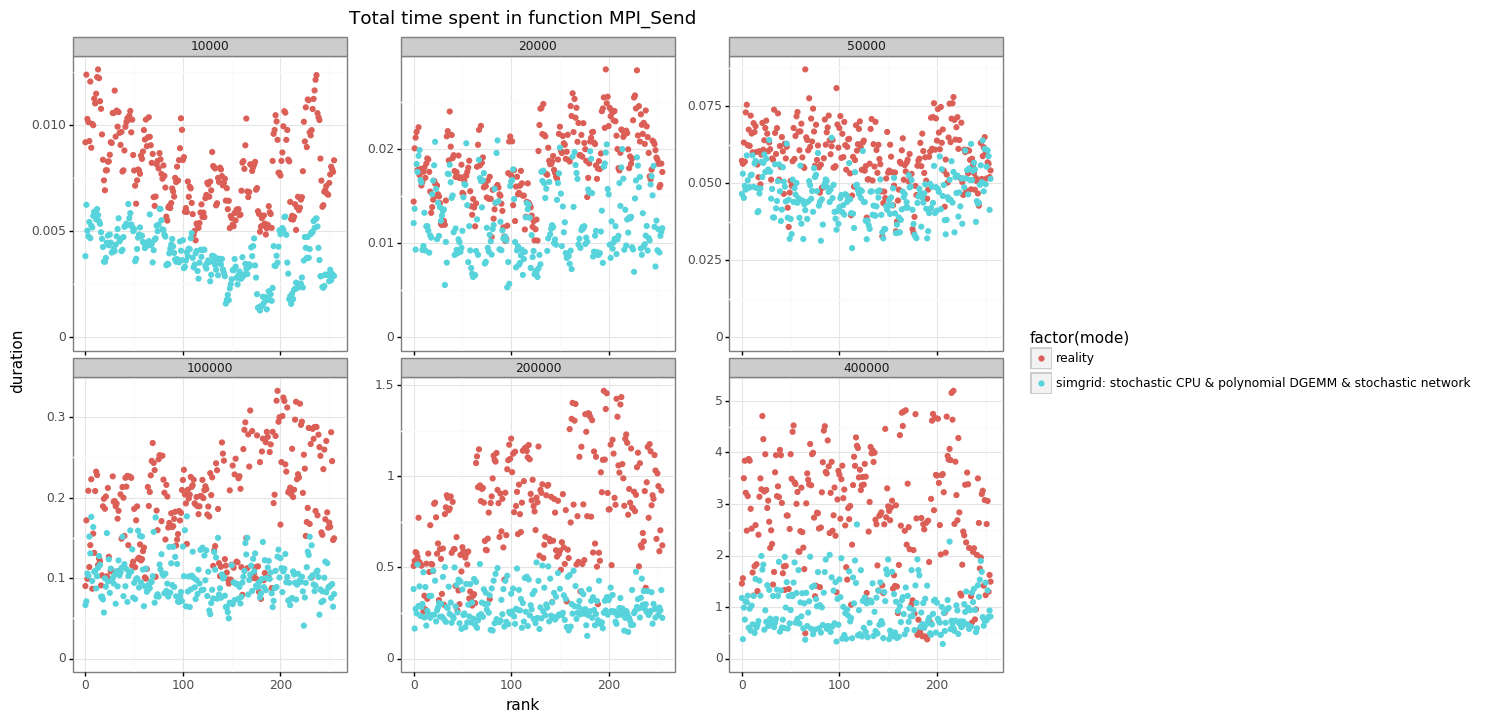

<ggplot: (-9223363242778105540)>


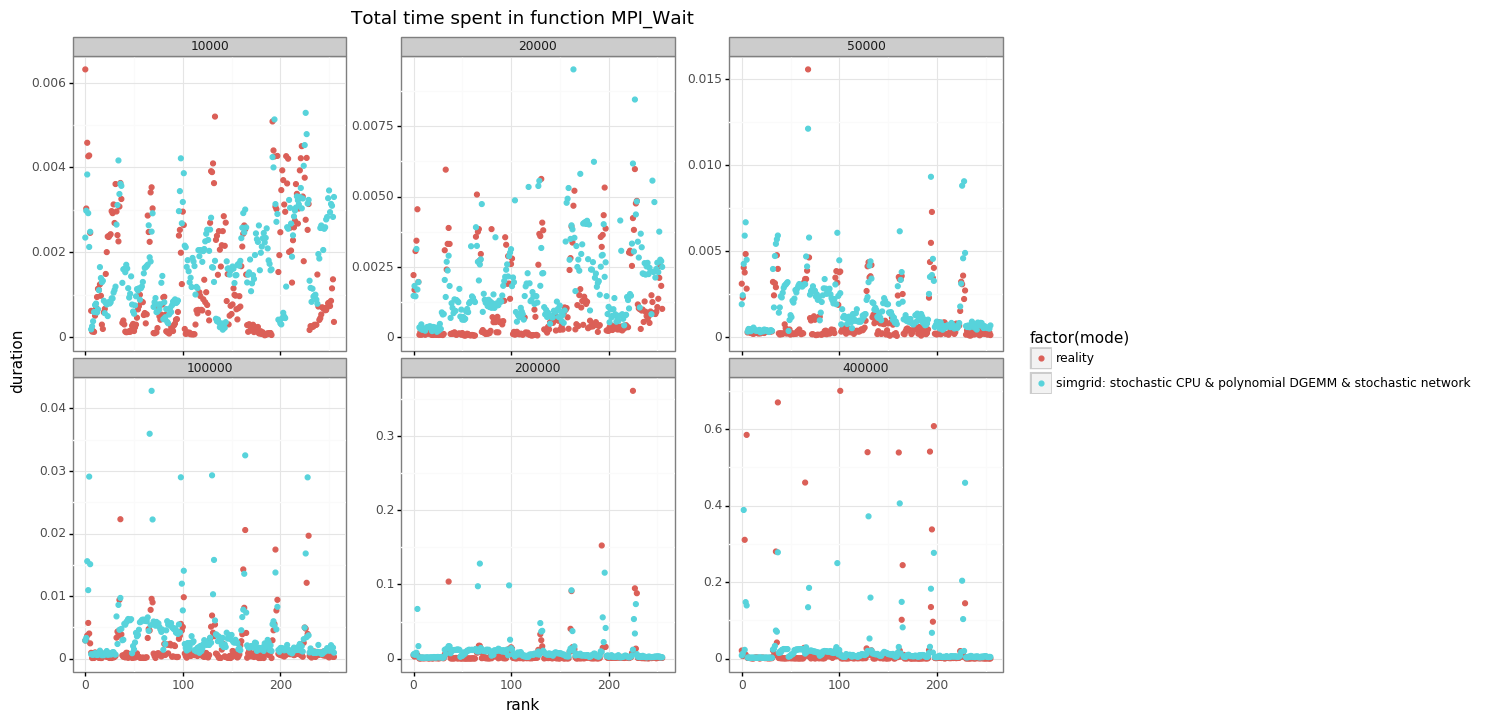

<ggplot: (-9223363242778969845)>


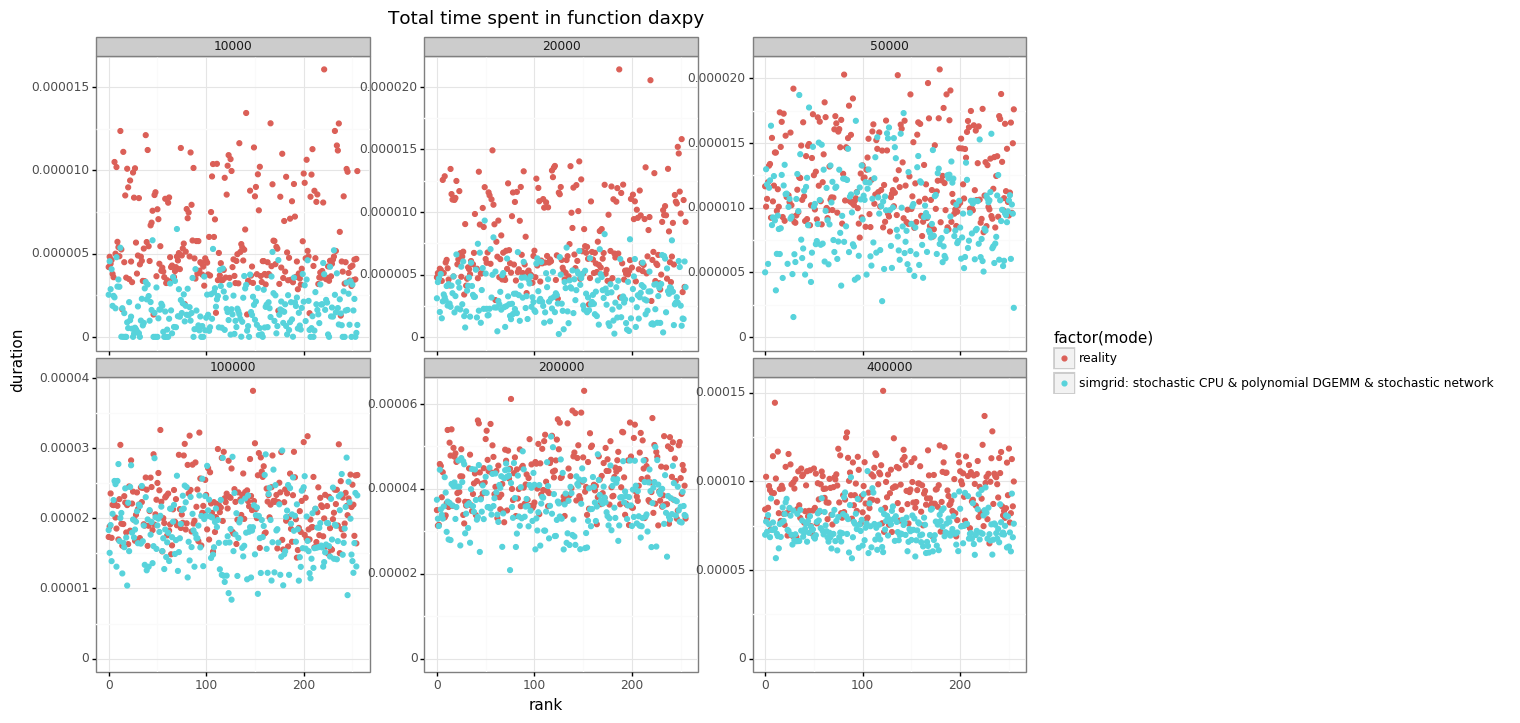

<ggplot: (8794075331311)>


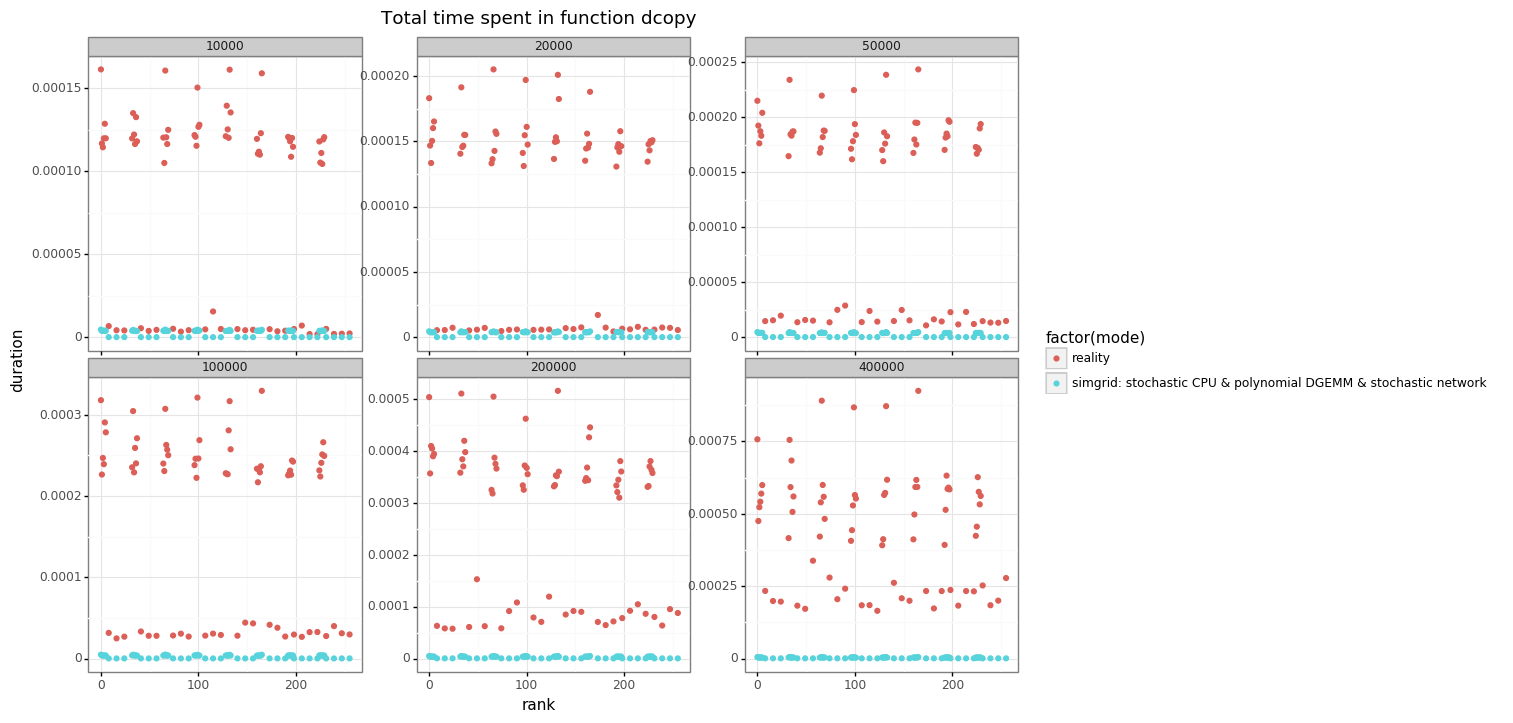

<ggplot: (-9223363242776450090)>


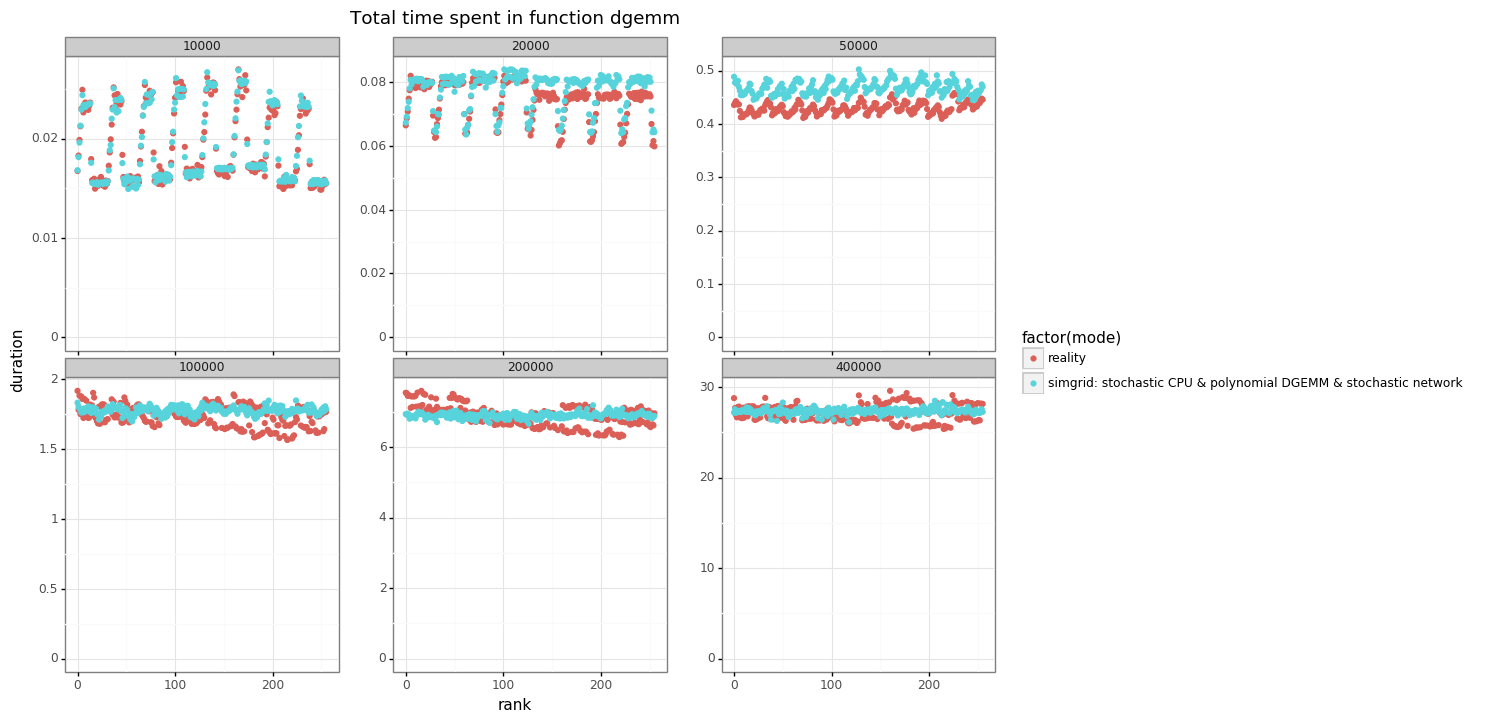

<ggplot: (8794075254827)>


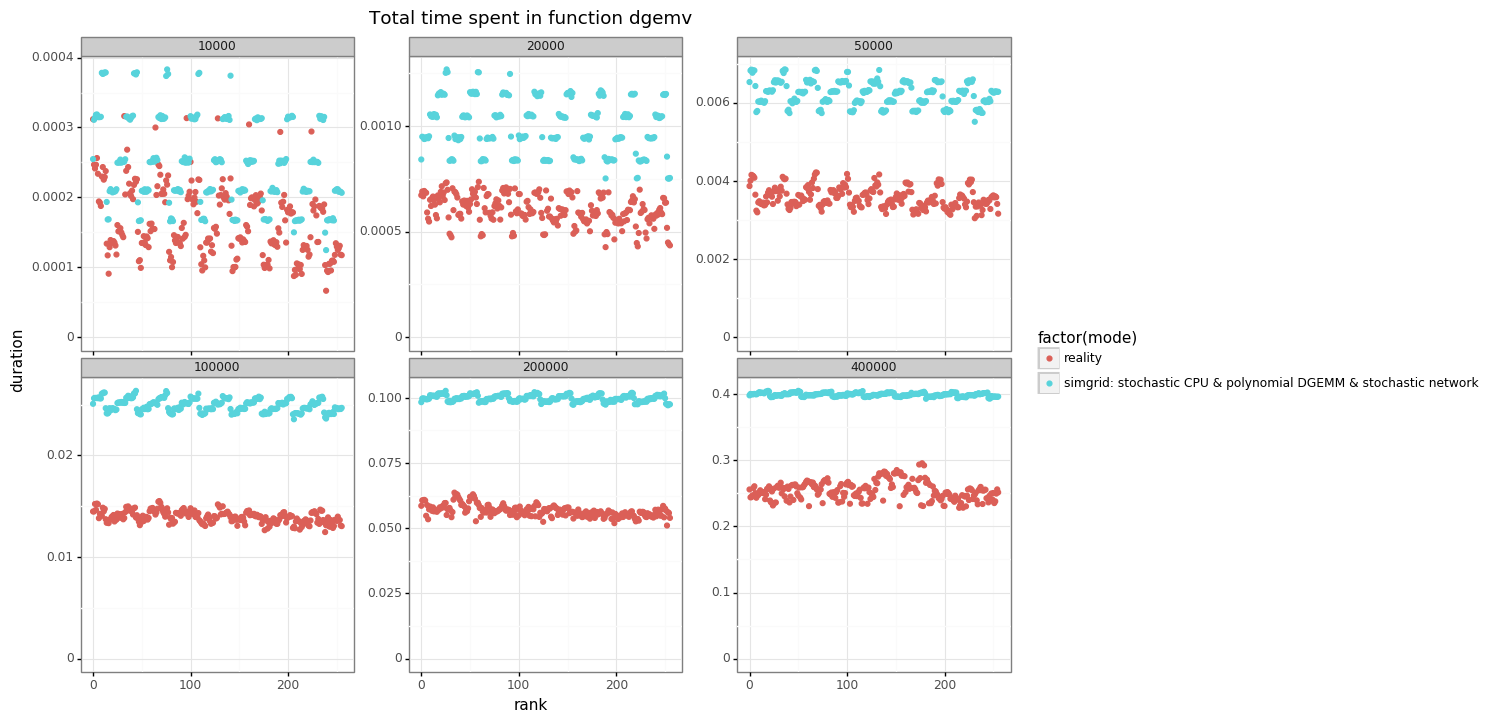

<ggplot: (8794076725312)>


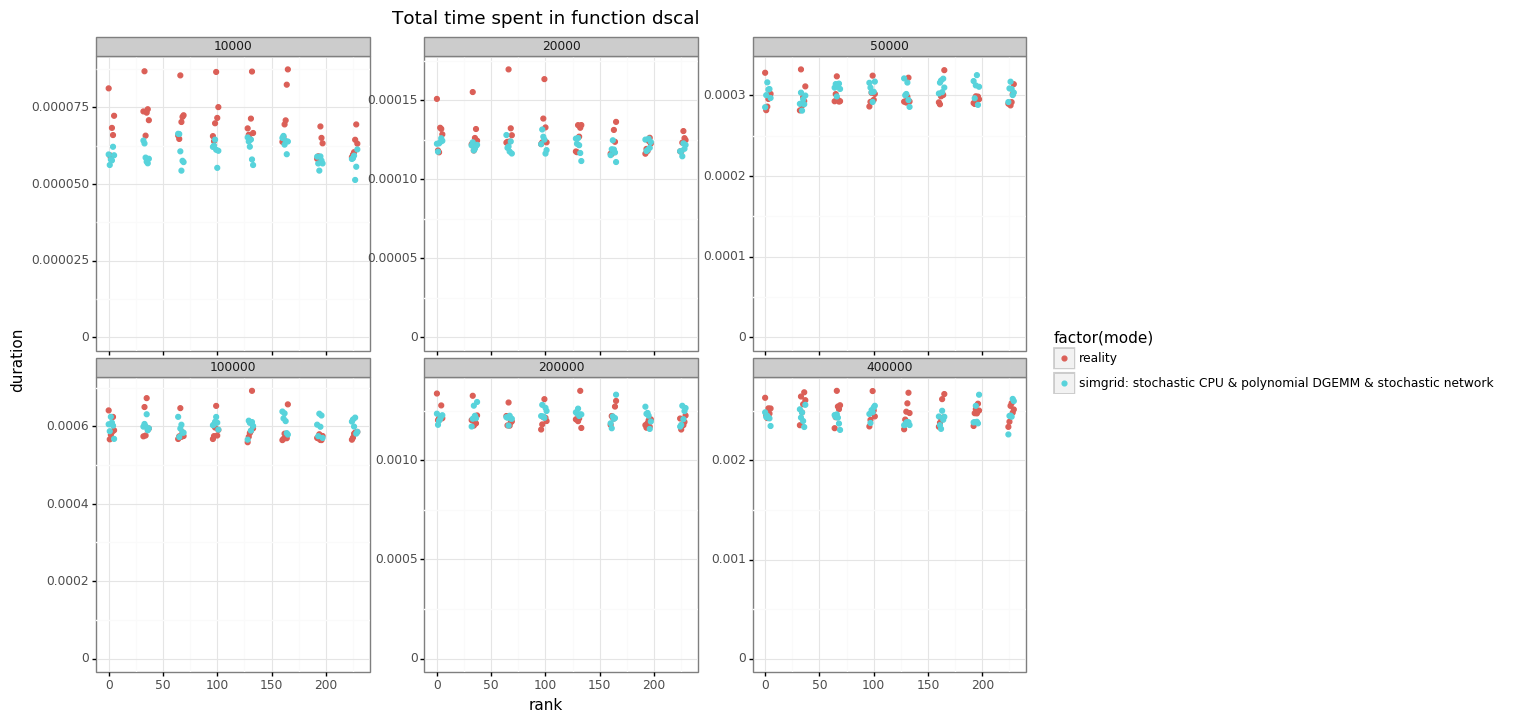

<ggplot: (8794075449001)>


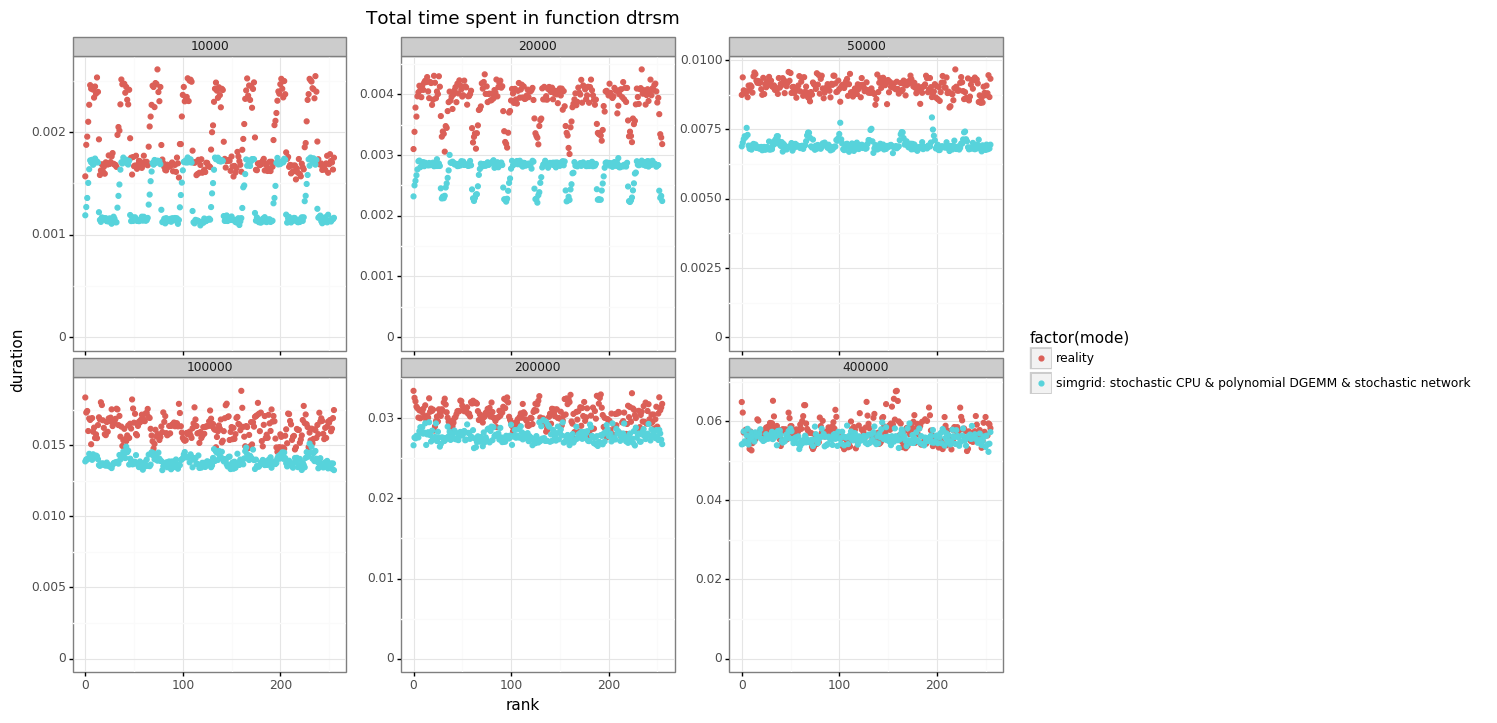

<ggplot: (-9223363242777443861)>


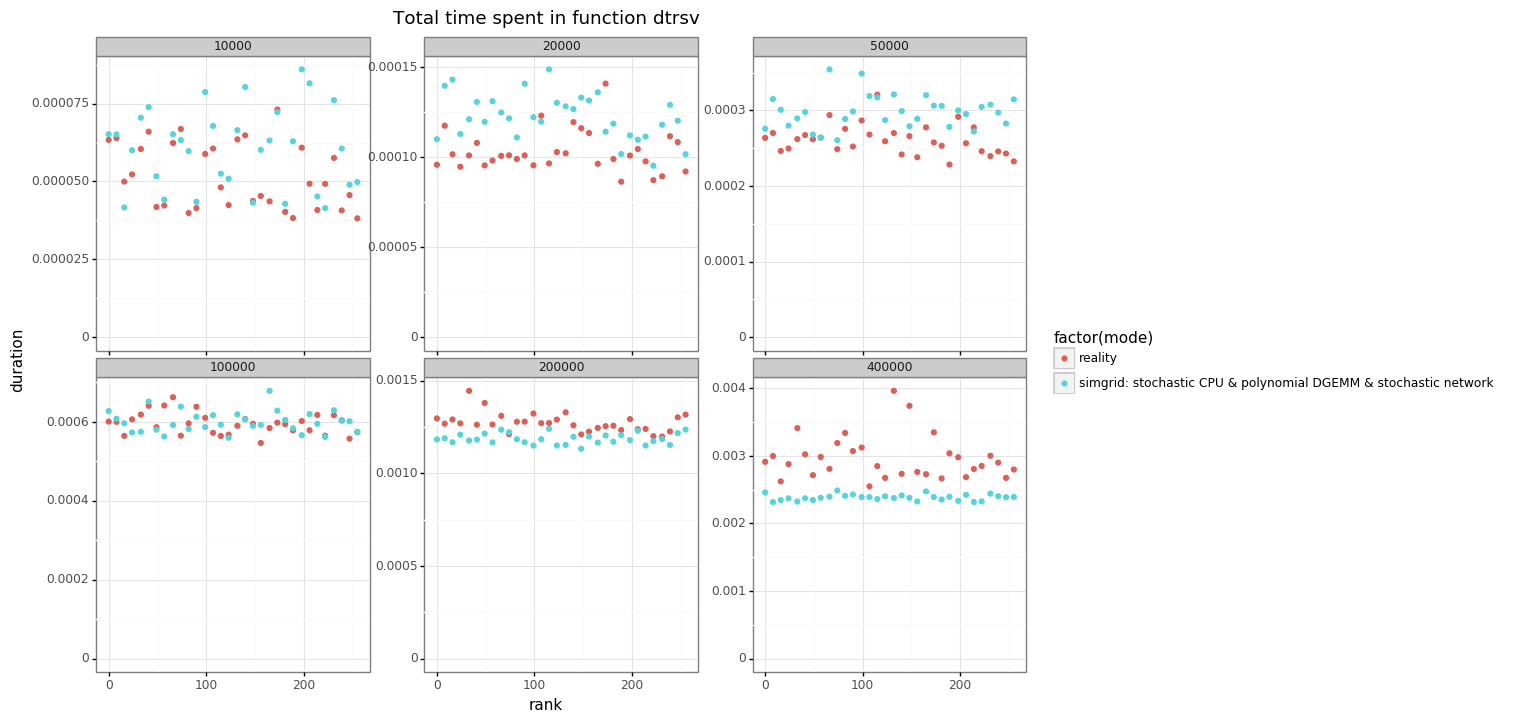

<ggplot: (8794075073428)>


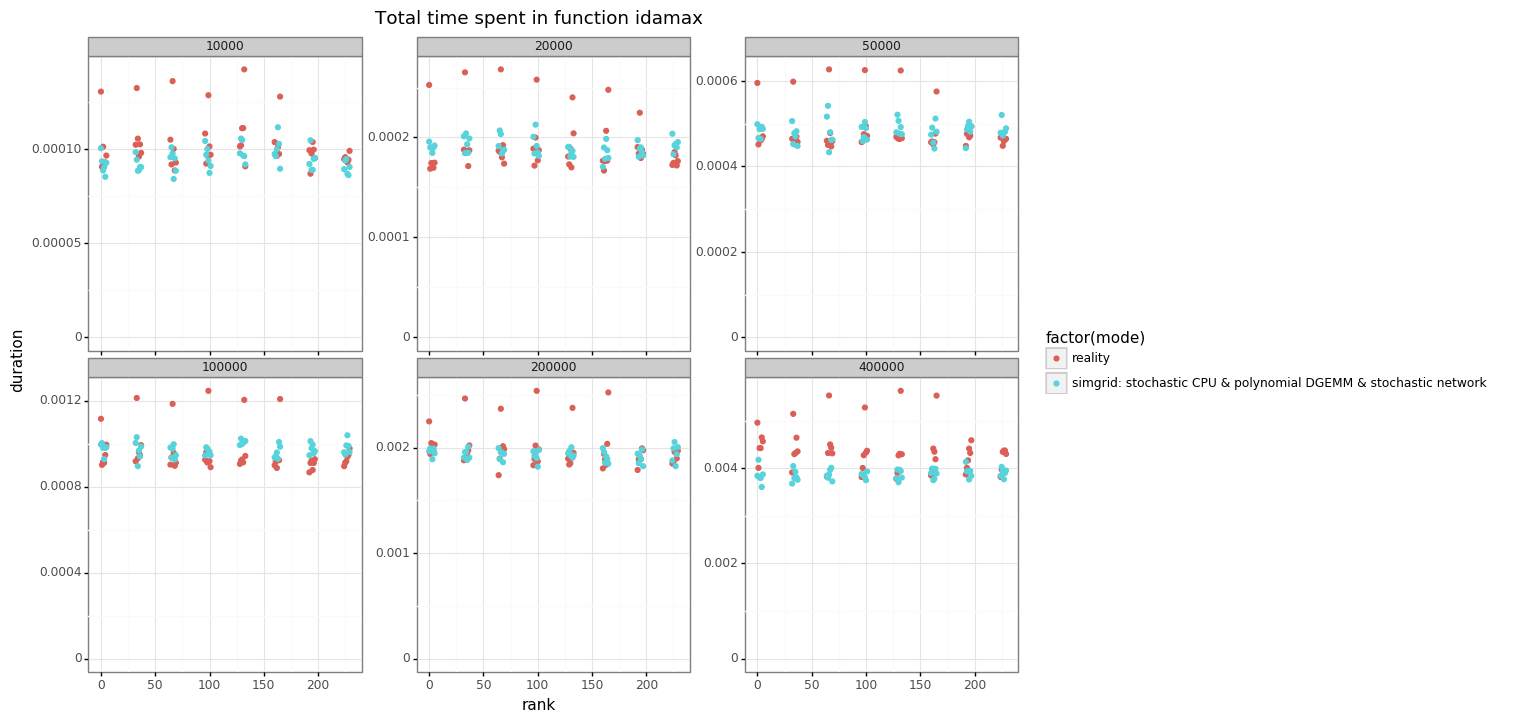

<ggplot: (8794076024328)>


In [15]:
for func in sorted(set(traces[traces['mode'].str.startswith('simgrid')].function.unique()) & set(traces[traces['mode'] == 'reality'].function.unique()) - {'MPI_Bcast', 'smpi_marker', 'MPI_Irecv'}):
    plot_total_duration(traces, func)

## Comparing the communications

In [16]:
def compute_cumsum(df, column, functions):
    dataframes = []
    for mode in df['mode'].unique():
        for function in functions:
            cols = ['start', 'end', 'function', 'mode'] + [column]
            tmp = df[(df['mode'] == mode) & (df['function'] == function)][cols].copy()
            tmp = tmp.sort_values(by=['start'])
            tmp['cumsum'] = tmp[column].cumsum()
            dataframes.append(tmp)
    return pandas.concat(dataframes)

In [17]:
tmp = traces[traces['function'].isin(['MPI_Recv', 'MPI_Send'])].copy().reset_index(drop=True)
tmp.groupby(['matrix_size', 'function', 'mode']).sum()[['msg_size', 'duration']]

msg_size  \
matrix_size function mode                                                               
10000       MPI_Recv reality                                               2018442752   
                     simgrid: stochastic CPU & polynomial DGEMM & st...    2018422272   
            MPI_Send reality                                               2594251456   
                     simgrid: stochastic CPU & polynomial DGEMM & st...    2602652448   
20000       MPI_Recv reality                                               3926118784   
                     simgrid: stochastic CPU & polynomial DGEMM & st...    3926096256   
            MPI_Send reality                                               5074191984   
                     simgrid: stochastic CPU & polynomial DGEMM & st...    5092505600   
50000       MPI_Recv reality                                               9649146880   
                     simgrid: stochastic CPU & polynomial DGEMM & st...    9649123328   
            MPI_Send reality                                              12577150208   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   12533449904   
100000      MPI_Recv reality                                              19187558784   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   19187538304   
            MPI_Send reality                                              24940018336   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   25032876016   
200000      MPI_Recv reality                                              38264350848   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   38264331392   
            MPI_Send reality                                              49953870080   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   49918449056   
400000      MPI_Recv reality                                              76421134976   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   76421111424   
            MPI_Send reality                                             100021131616   
                     simgrid: stochastic CPU & polynomial DGEMM & st...   99384311280   

                                                                           duration  
matrix_size function mode                                                            
10000       MPI_Recv reality                                               3.684690  
                     simgrid: stochastic CPU & polynomial DGEMM & st...    2.870760  
            MPI_Send reality                                               2.033219  
                     simgrid: stochastic CPU & polynomial DGEMM & st...    0.979529  
20000       MPI_Recv reality                                              10.224674  
                     simgrid: stochastic CPU & polynomial DGEMM & st...    6.754350  
            MPI_Send reality                                               4.727888  
                     simgrid: stochastic CPU & polynomial DGEMM & st...    3.142994  
50000       MPI_Recv reality                                              27.952902  
                     simgrid: stochastic CPU & polynomial DGEMM & st...   22.593168  
            MPI_Send reality                                              15.110035  
                     simgrid: stochastic CPU & polynomial DGEMM & st...   11.779542  
100000      MPI_Recv reality                                              66.401595  
                     simgrid: stochastic CPU & polynomial DGEMM & st...   48.420665  
            MPI_Send reality                                              49.409897  
                     simgrid: stochastic CPU & polynomial DGEMM & st...   25.423547  
200000      MPI_Recv reality                                             161.443587  
                     simgrid: stochastic CPU & polynomial DGEMM & st...  103.314032  
            MPI_Send reality              

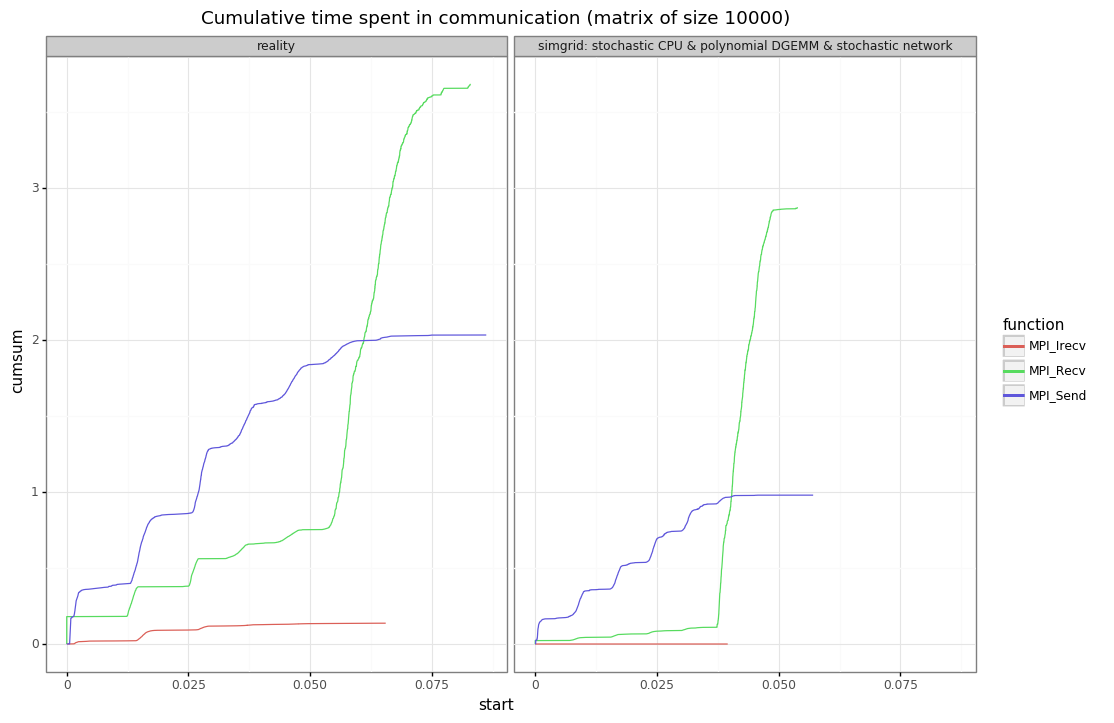

<ggplot: (8794079586610)>


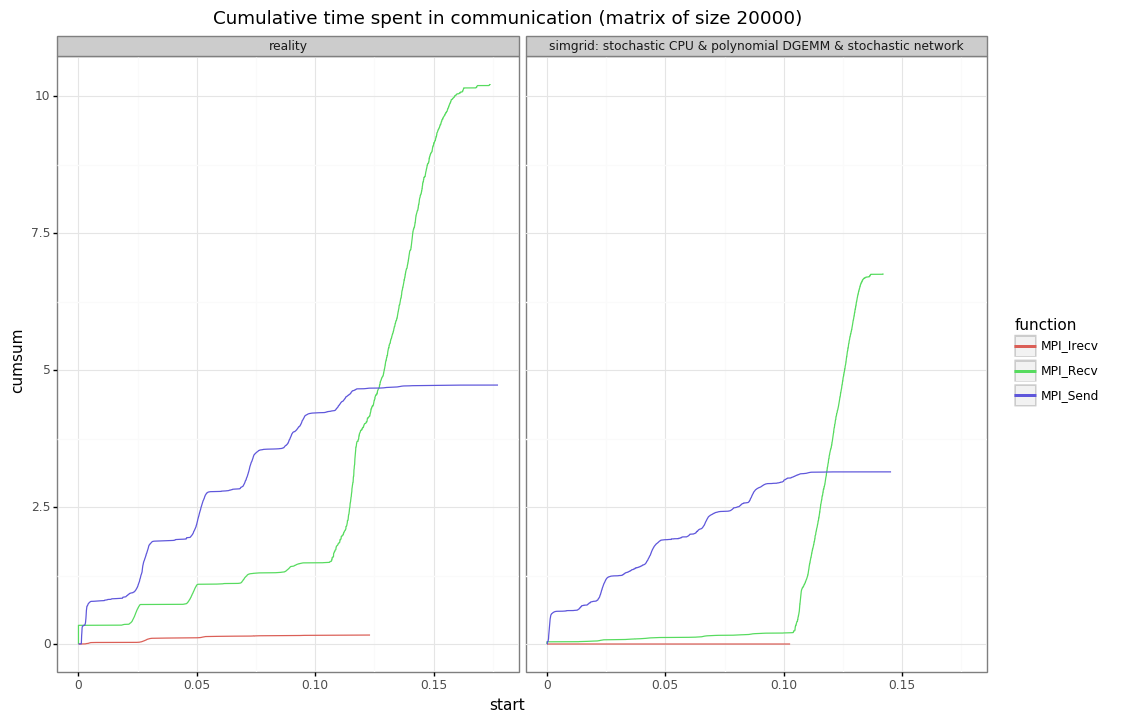

<ggplot: (-9223363242779514315)>


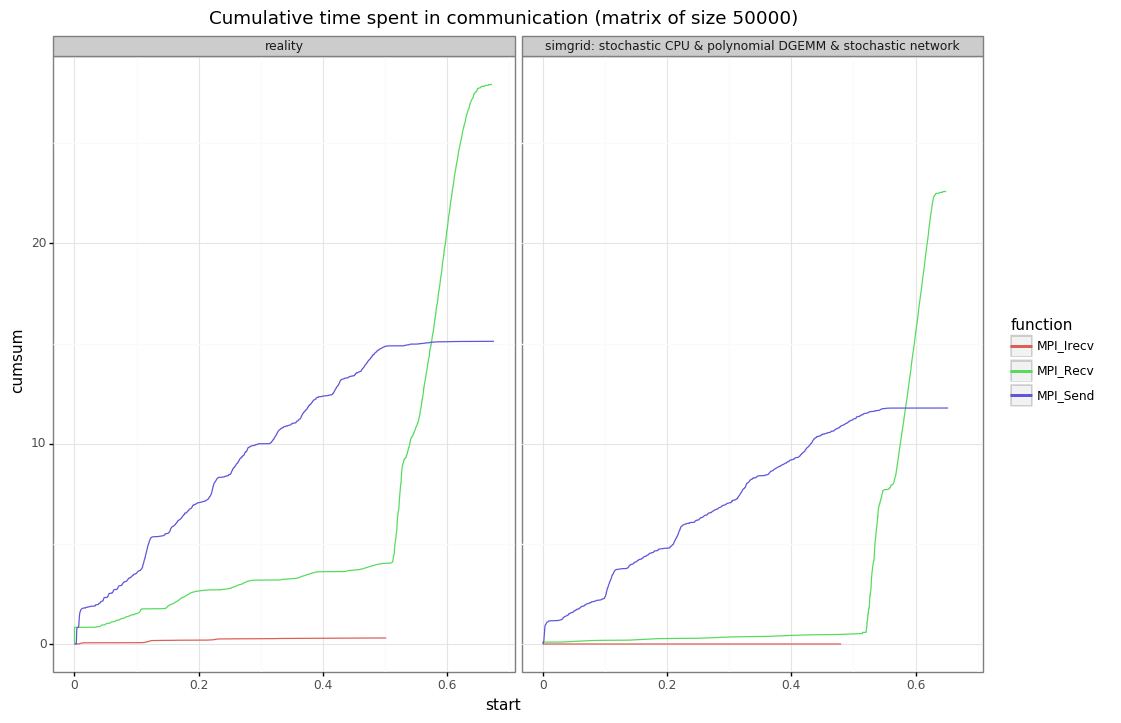

<ggplot: (-9223363242780382355)>


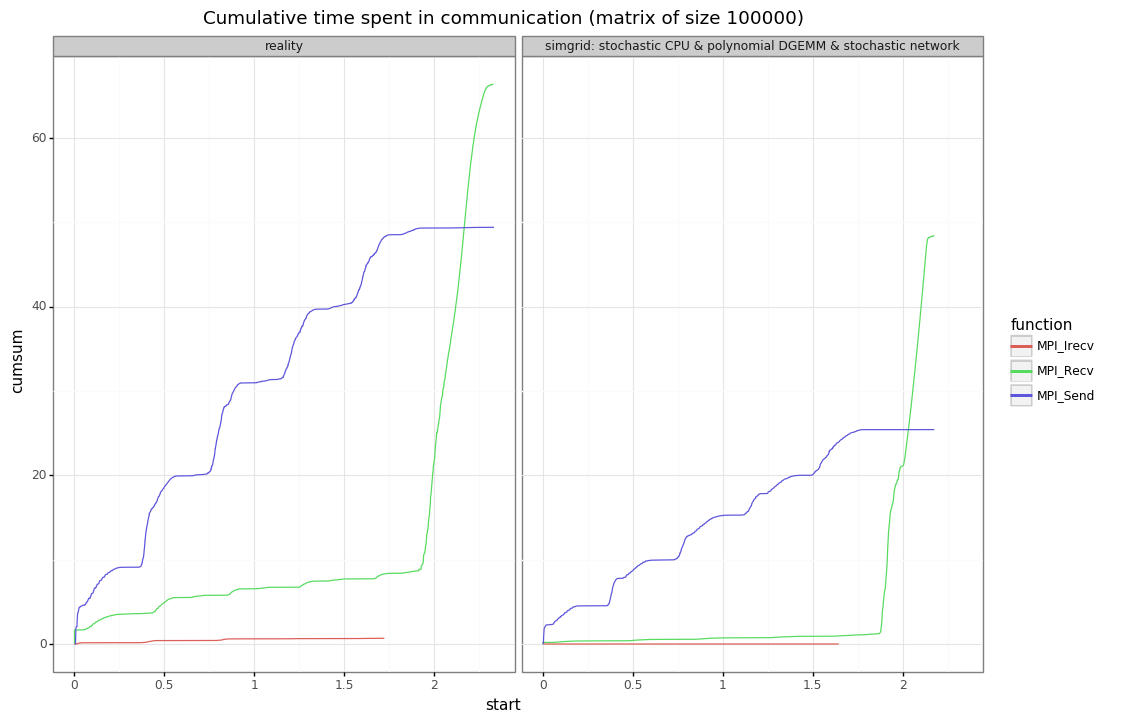

<ggplot: (8794076059119)>


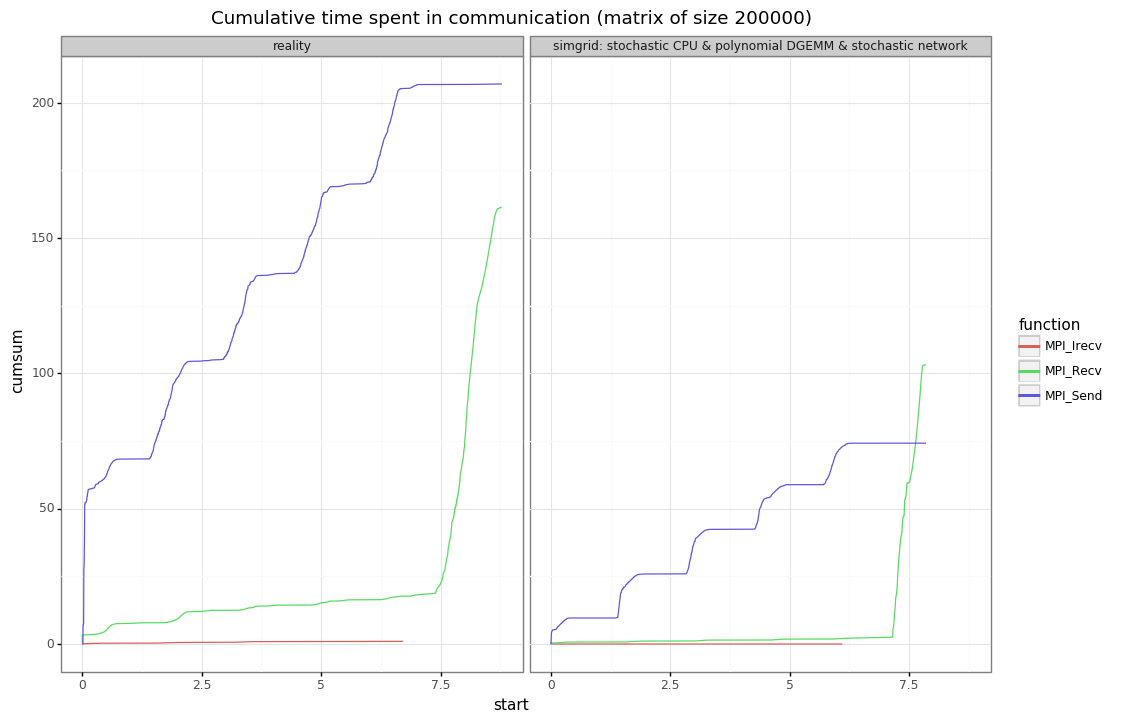

<ggplot: (8794079417057)>


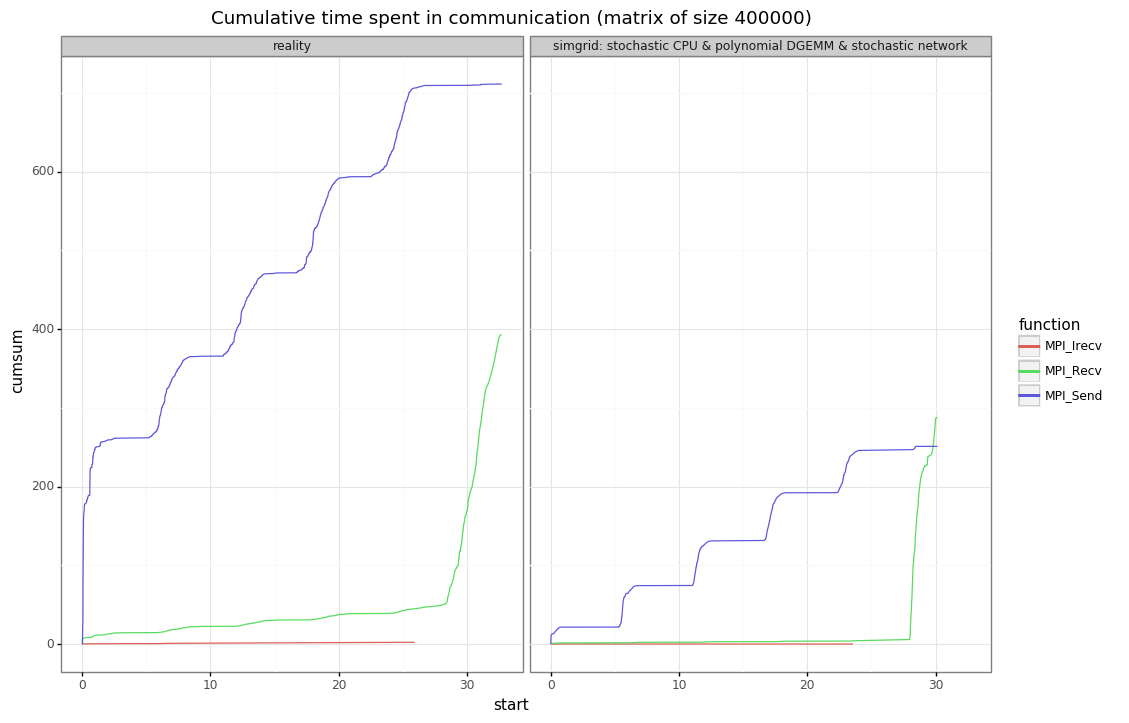

<ggplot: (-9223363242832881909)>


In [18]:
for size in sorted(traces['matrix_size'].unique()):
    plot = ggplot(compute_cumsum(traces[traces['matrix_size'] == size], 'duration', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
    print(plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in communication (matrix of size %d)' % size))

## Comparing the computations

In [19]:
tmp = traces[traces['function'].isin(['dgemm', 'dtrsm'])].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2

In [20]:
tmp.groupby(['matrix_size', 'function', 'mode']).sum()[['size_product', 'duration']]

size_product  \
matrix_size function mode                                                               
10000       dgemm    reality                                             5.967156e+10   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  5.967156e+10   
            dtrsm    reality                                             6.319370e+09   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  6.319370e+09   
20000       dgemm    reality                                             2.472466e+11   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  2.472466e+11   
            dtrsm    reality                                             1.287297e+10   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  1.287297e+10   
50000       dgemm    reality                                             1.577972e+12   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  1.577972e+12   
            dtrsm    reality                                             3.253377e+10   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  3.253377e+10   
100000      dgemm    reality                                             6.355847e+12   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  6.355847e+12   
            dtrsm    reality                                             6.530177e+10   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  6.530177e+10   
200000      dgemm    reality                                             2.551160e+13   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  2.551160e+13   
            dtrsm    reality                                             1.308378e+11   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  1.308378e+11   
400000      dgemm    reality                                             1.022231e+14   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  1.022231e+14   
            dtrsm    reality                                             2.619098e+11   
                     simgrid: stochastic CPU & polynomial DGEMM & st...  2.619098e+11   

                                                                            duration  
matrix_size function mode                                                             
10000       dgemm    reality                                                4.894514  
                     simgrid: stochastic CPU & polynomial DGEMM & st...     4.923796  
            dtrsm    reality                                                0.496590  
                     simgrid: stochastic CPU & polynomial DGEMM & st...     0.344273  
20000       dgemm    reality                                               19.233083  
                     simgrid: stochastic CPU & polynomial DGEMM & st...    19.895555  
            dtrsm    reality                                                0.991111  
                     simgrid: stochastic CPU & polynomial DGEMM & st...     0.699900  
50000       dgemm    reality                                              109.941501  
                     simgrid: stochastic CPU & polynomial DGEMM & st...   119.636906  
            dtrsm    reality                                                2.307983  
                     simgrid: stochastic CPU & polynomial DGEMM & st...     1.775220  
100000      dgemm    reality                                              443.637934  
                     simgrid: stochastic CPU & polynomial DGEMM & st...   455.396184  
            dtrsm    reality                                                4.156519  
                     simgrid: stochastic CPU & polynomial DGEMM & st...     3.554610  
200000      dgemm    reality                                             1762.140215  
                     simgrid: stochastic CPU & polynomial DGEMM & st...  1766.297301  
            dtrsm 

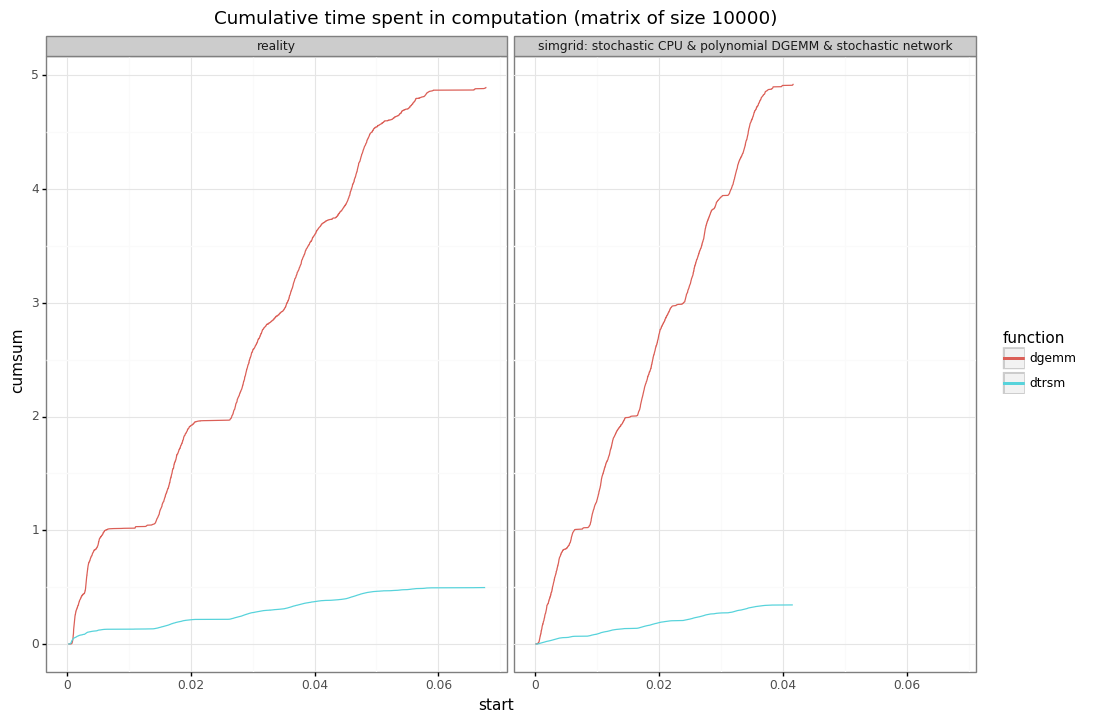

<ggplot: (-9223363242779266318)>


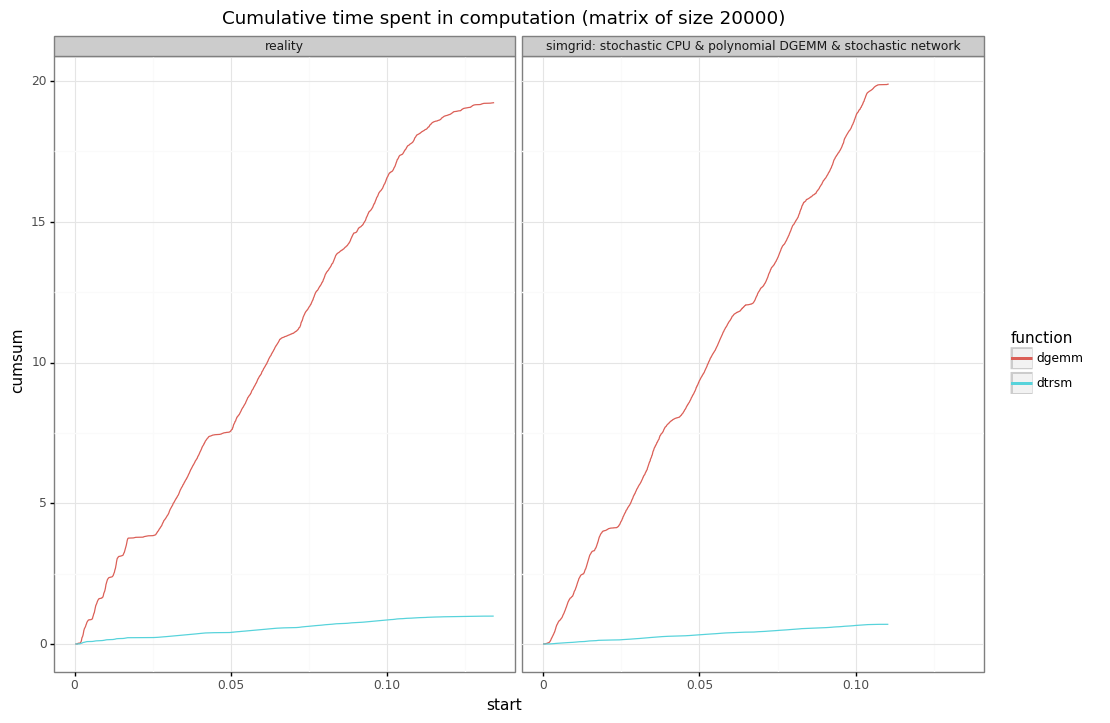

<ggplot: (-9223363242773444394)>


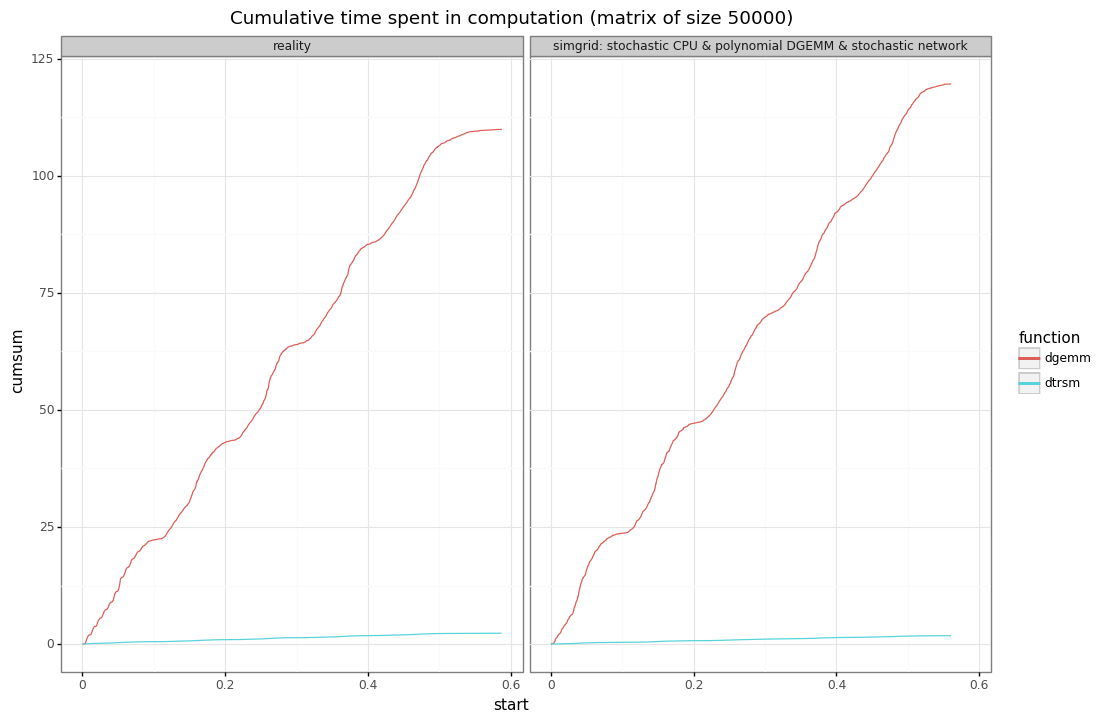

<ggplot: (-9223363242778497115)>


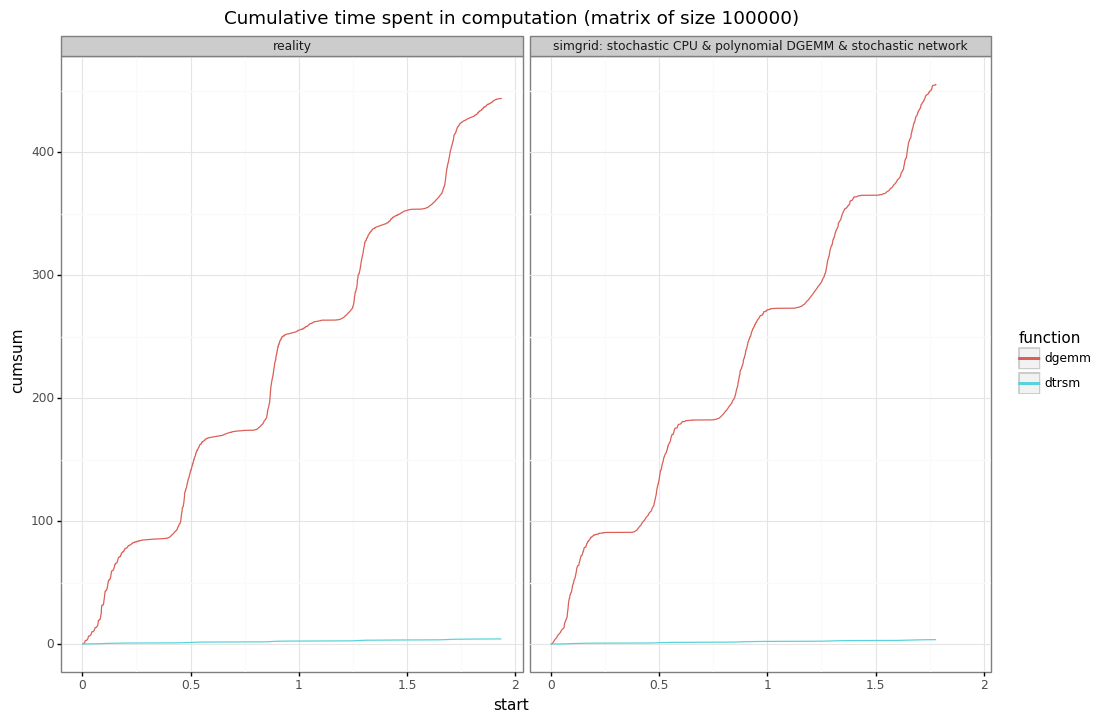

<ggplot: (8794077207104)>


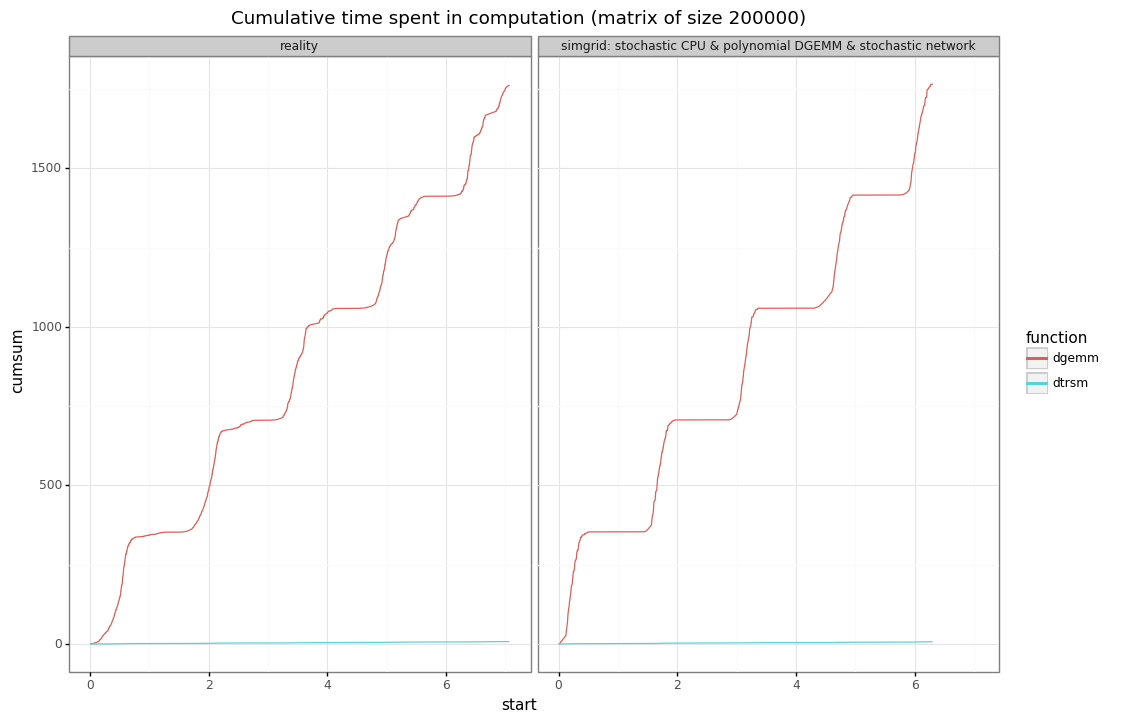

<ggplot: (8794075208424)>


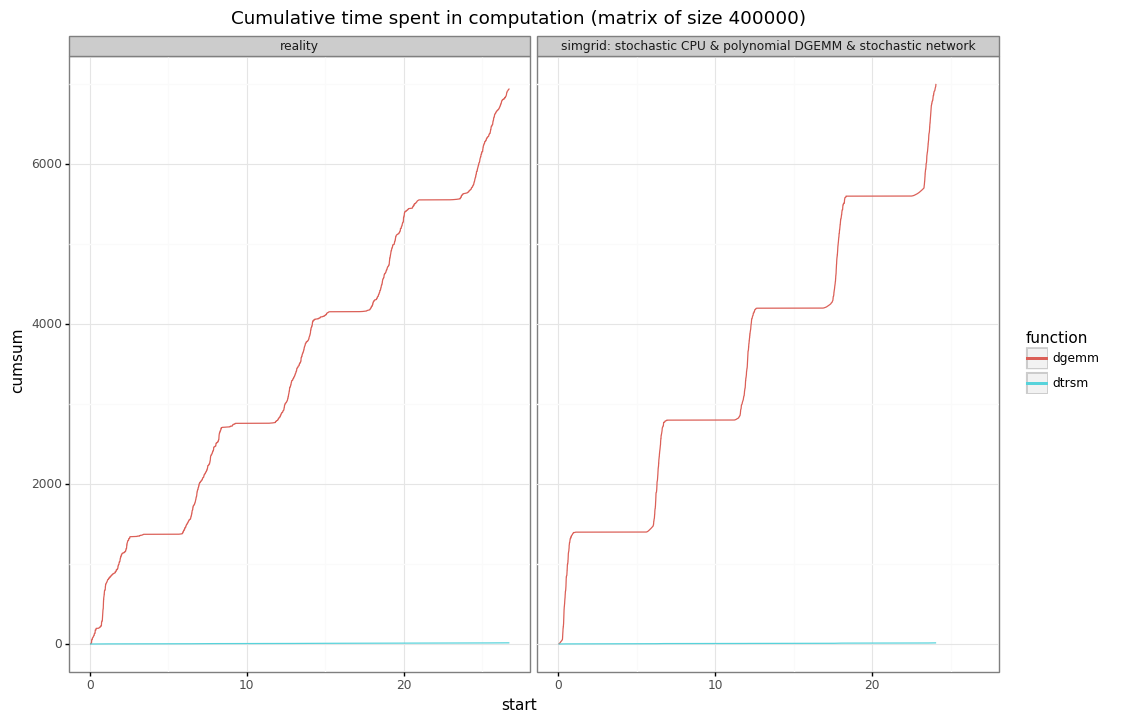

<ggplot: (8794076429597)>


In [21]:
for size in sorted(traces['matrix_size'].unique()):
    plot = ggplot(compute_cumsum(tmp[tmp['matrix_size'] == size], 'duration', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
    print(plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in computation (matrix of size %d)' % size))

## Plotting the durations

In [22]:
blas = traces[traces['kind'] == 'BLAS'].copy().reset_index()
blas['size_product'] = -1
blas.loc[blas.function == 'dgemm', 'size_product'] = blas.m * blas.n * blas.k
blas.loc[blas.function == 'dtrsm', 'size_product'] = blas.m * blas.n**2
blas.loc[blas.function == 'dtrsv', 'size_product'] = blas.m**2
for func in ['dgemv']:
    blas.loc[blas.function == func, 'size_product'] = blas.m * blas.n
for func in ['daxpy', 'dcopy', 'dscal', 'idamax']:
    blas.loc[blas.function == func, 'size_product'] = blas.m

blas.loc[blas.function.str.startswith('HPL_'), 'size_product'] = blas.m * blas.n
for func in ['HPL_dlaswp04N', 'HPL_dlaswp04T']:
    blas.loc[blas.function == func, 'size_product'] = blas.n * blas.k
blas = blas[blas.size_product > 0].copy()

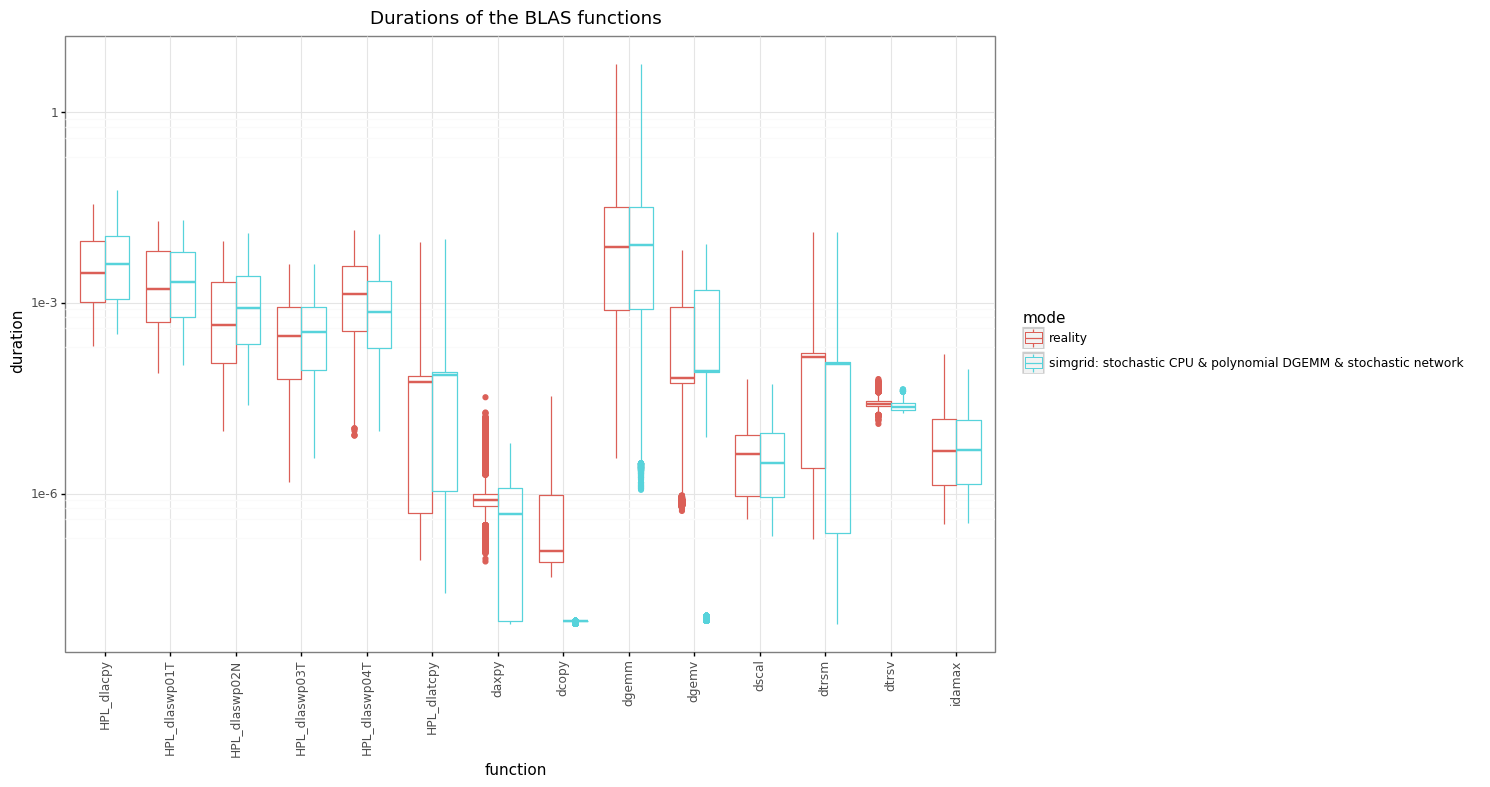

<ggplot: (-9223363242779026358)>

In [23]:
plot = ggplot(blas, aes(x='function', y='duration', color='mode')) + scale_y_log10()
plot = plot + theme_bw() + ggtitle('Durations of the BLAS functions') + geom_boxplot(alpha=0)
plot + theme(axis_text_x=element_text(rotation=90))

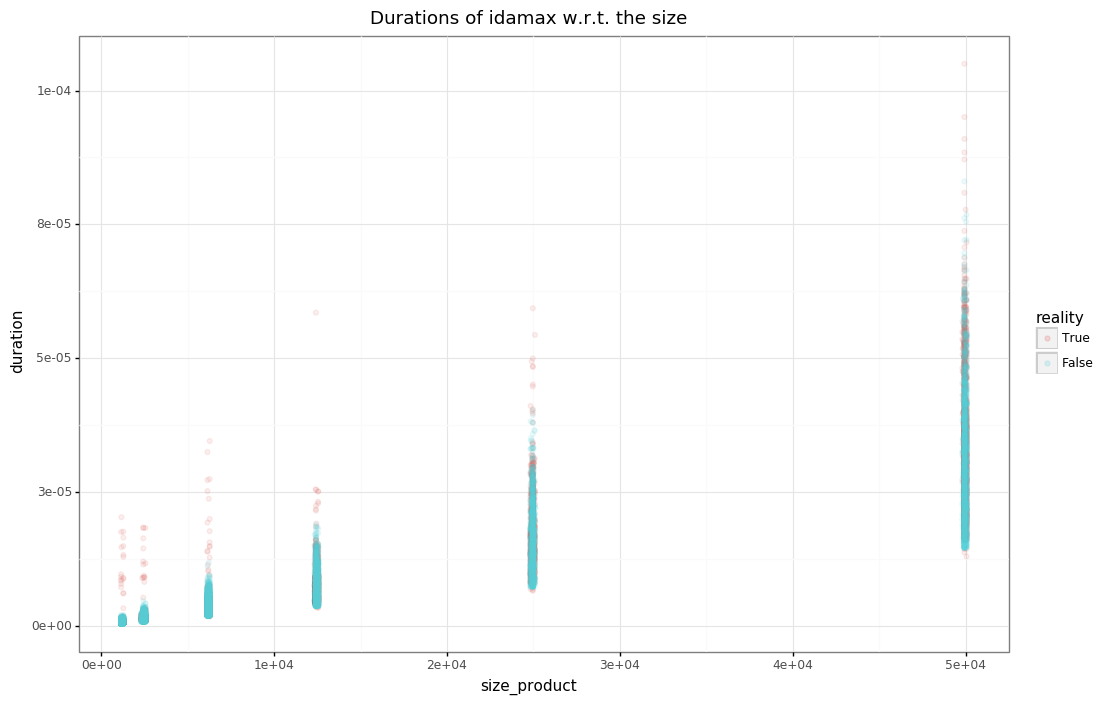

<ggplot: (8794081991502)>


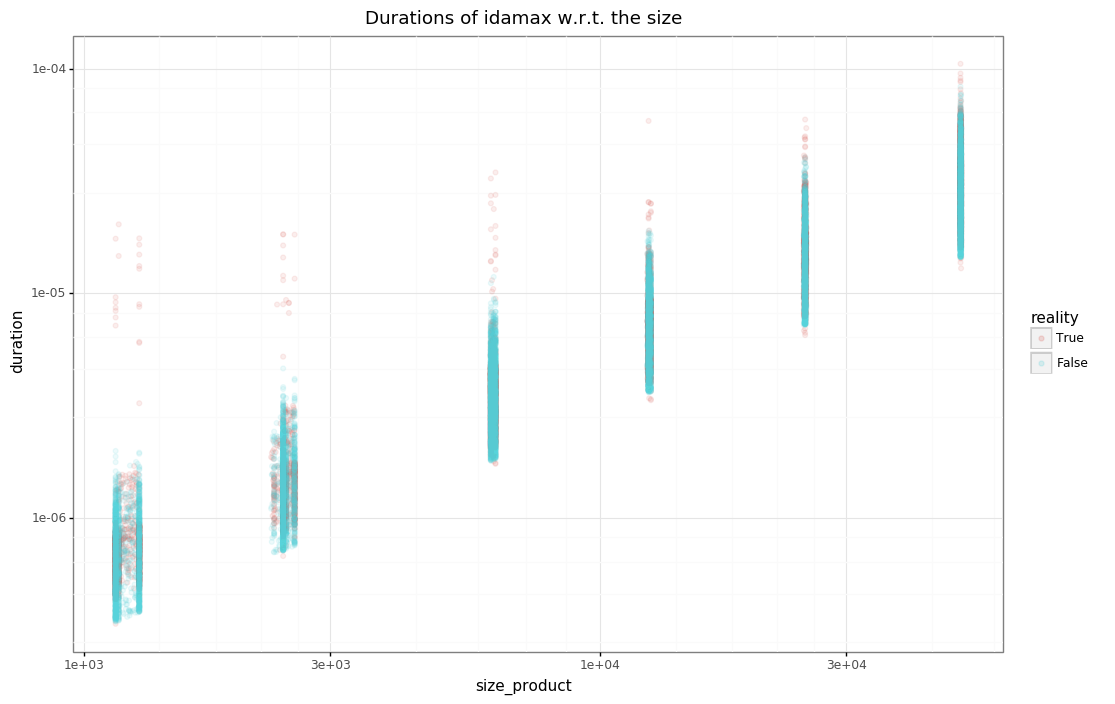

<ggplot: (-9223363242779289049)>


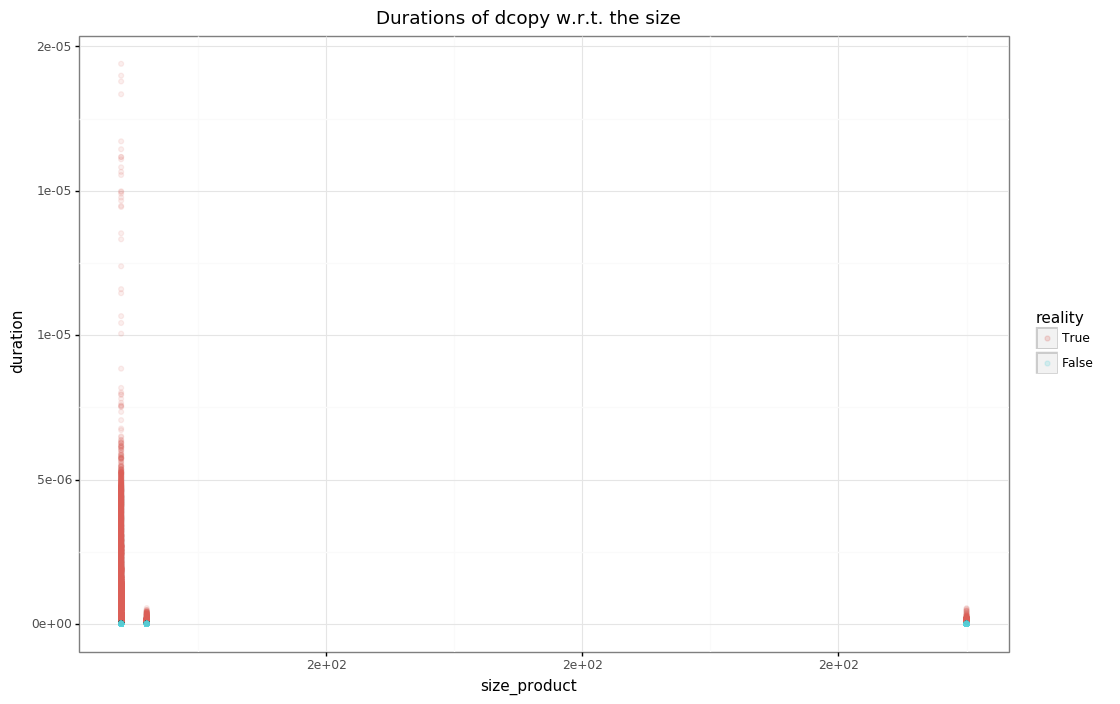

<ggplot: (8794076236345)>


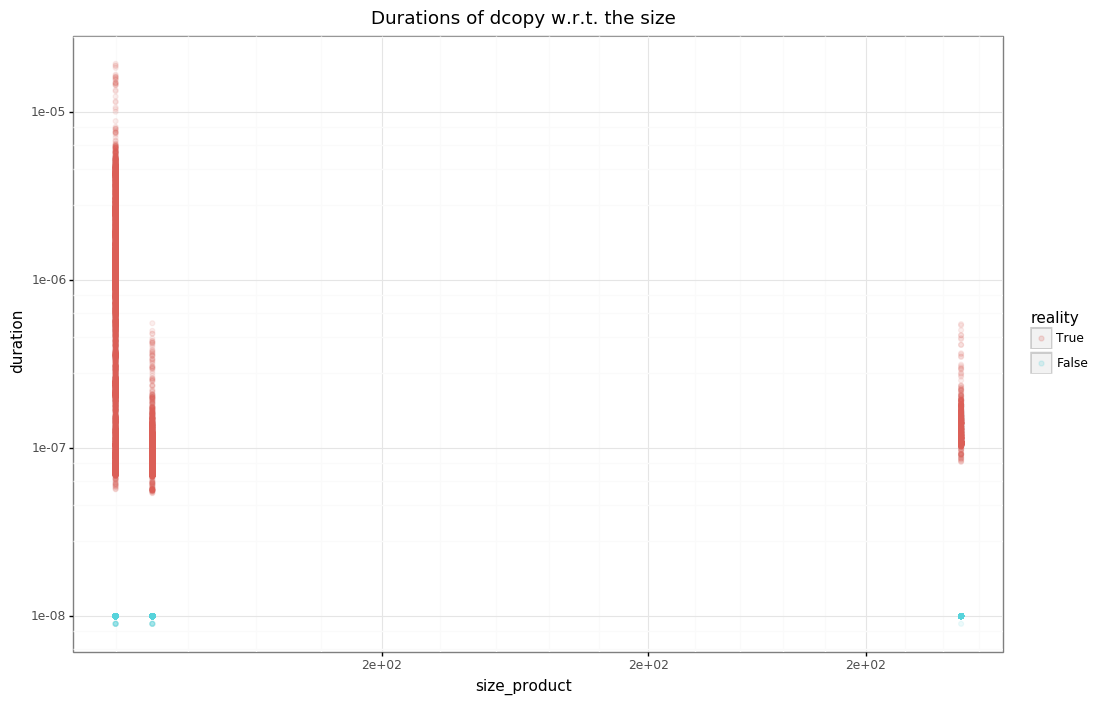

<ggplot: (-9223363242773103784)>


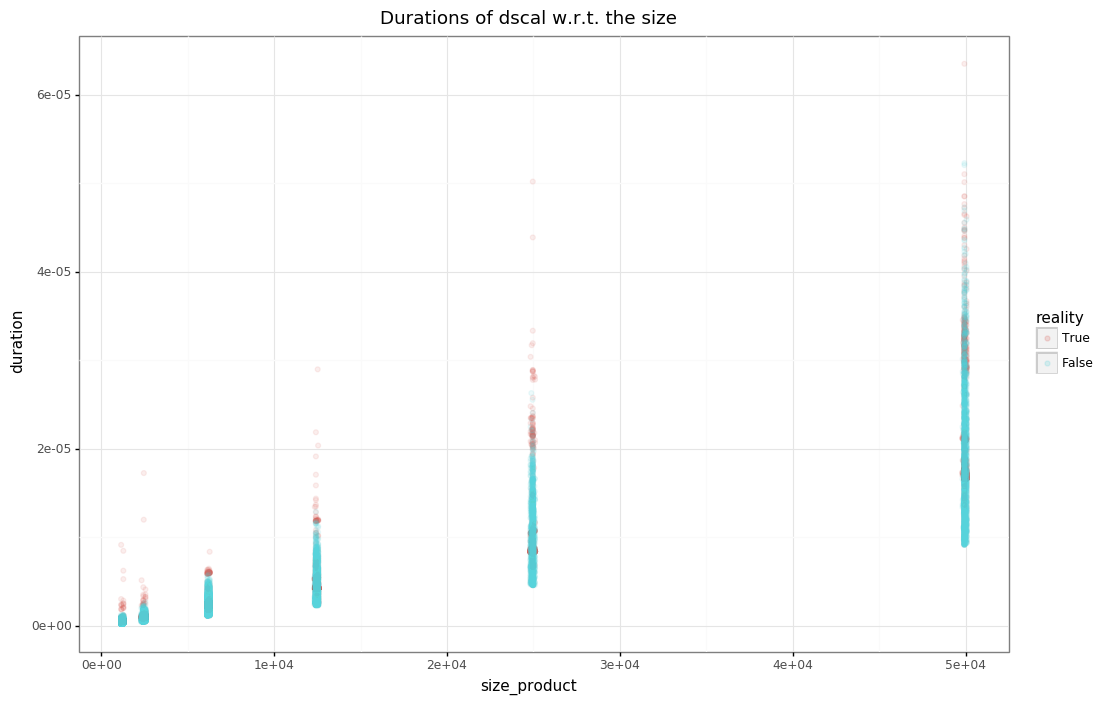

<ggplot: (-9223363242779936126)>


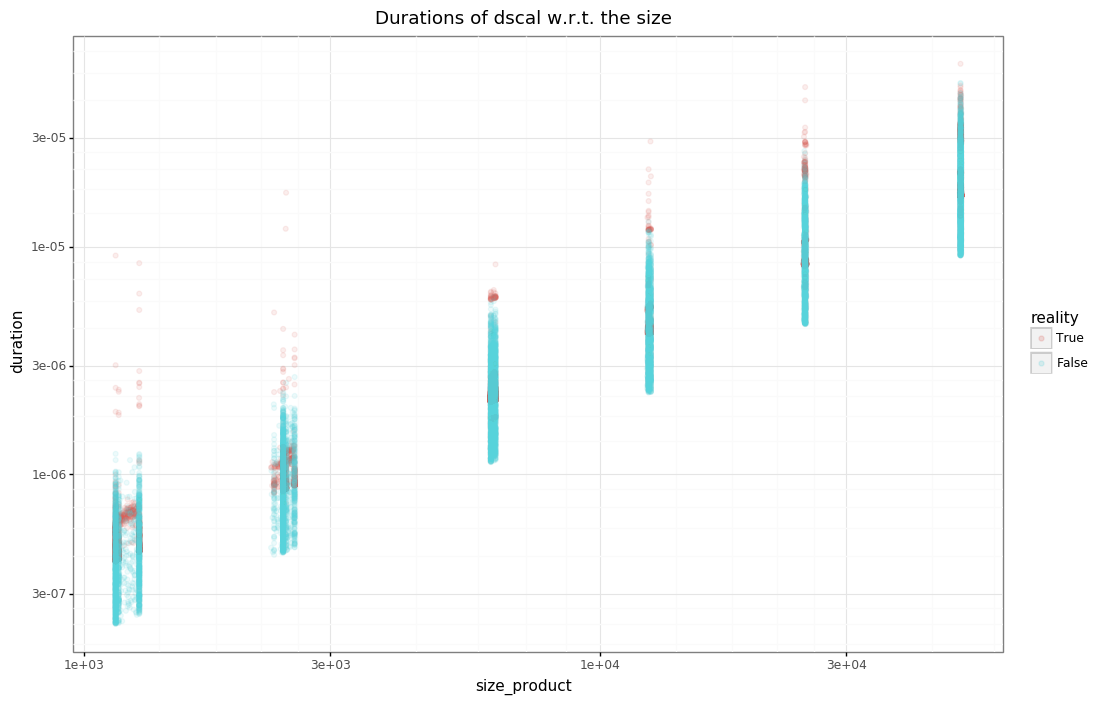

<ggplot: (8794080918171)>


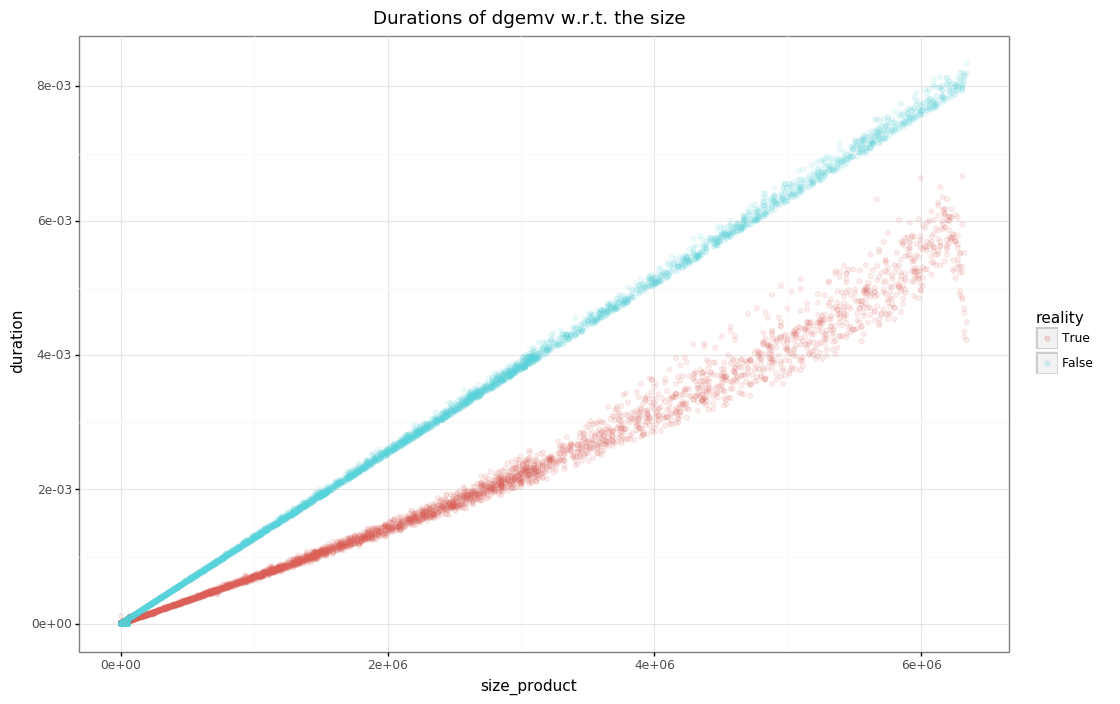

<ggplot: (8794076278571)>


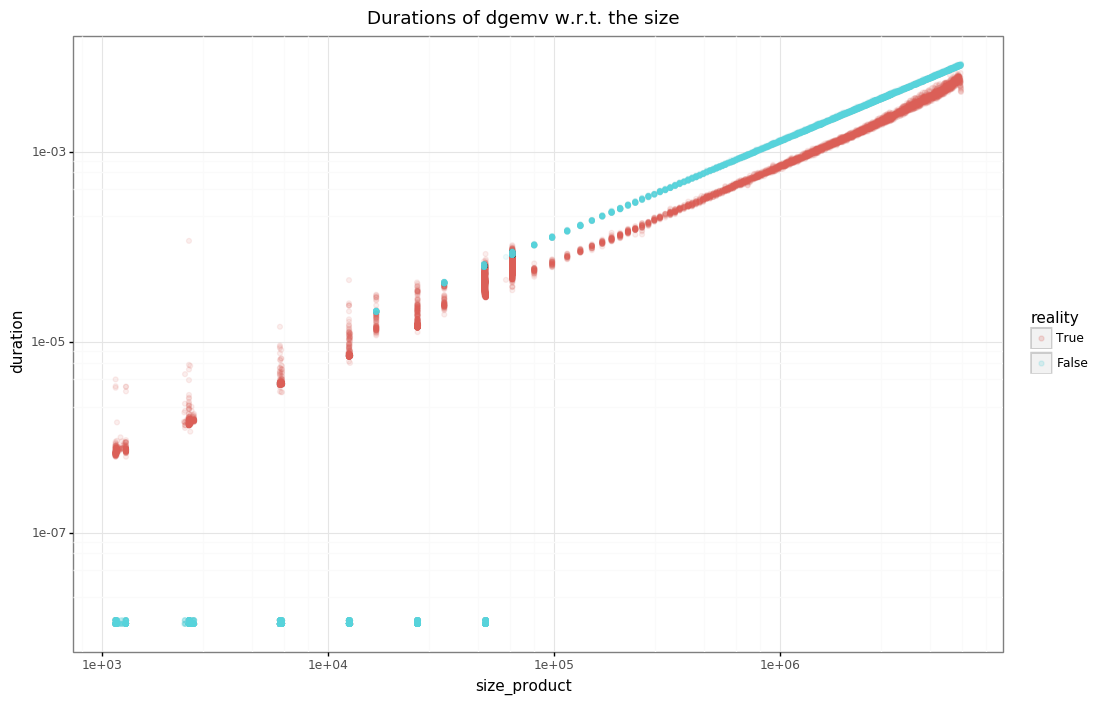

<ggplot: (-9223363242832879265)>


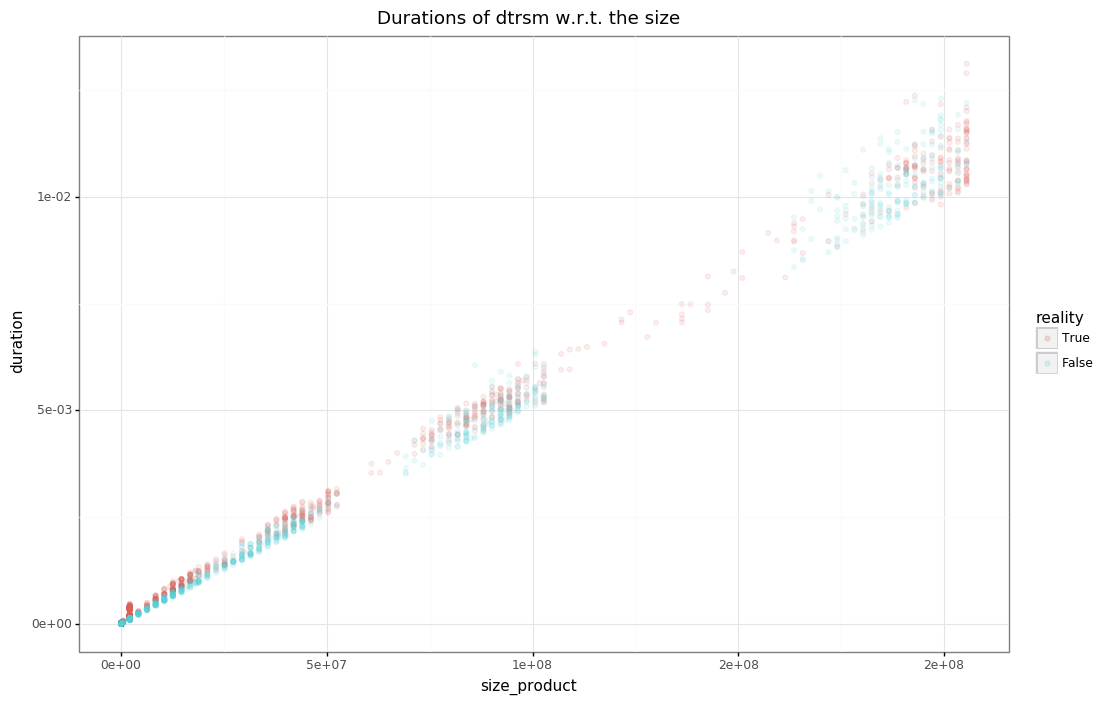

<ggplot: (-9223363242772746268)>


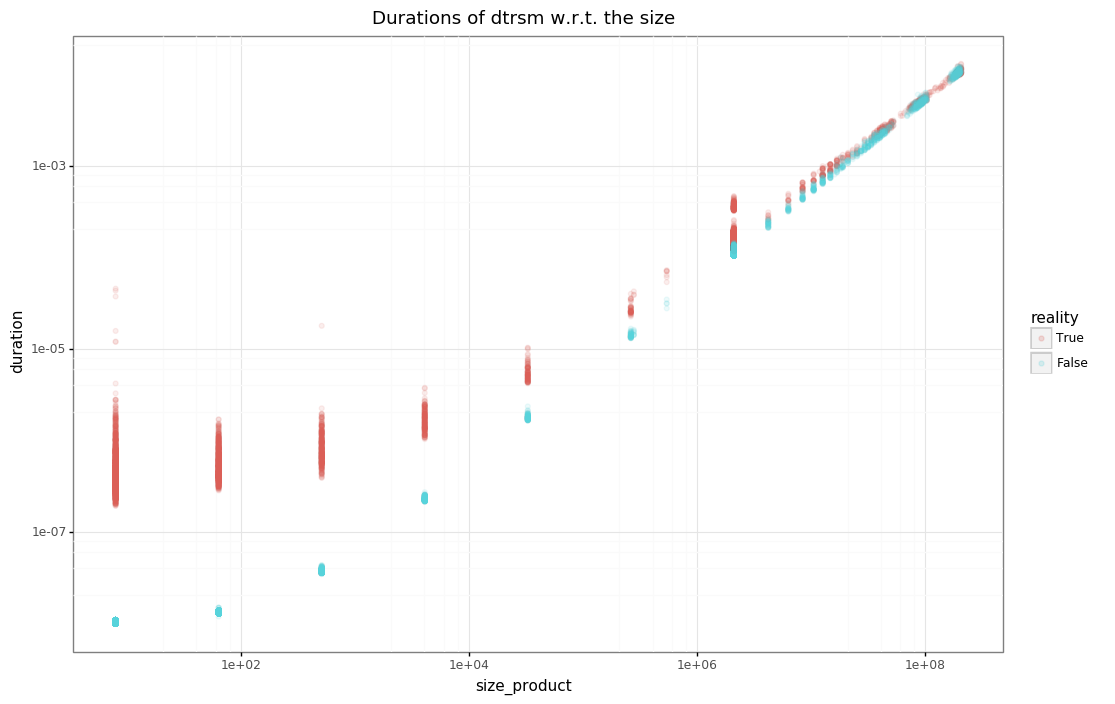

<ggplot: (-9223363242742592196)>


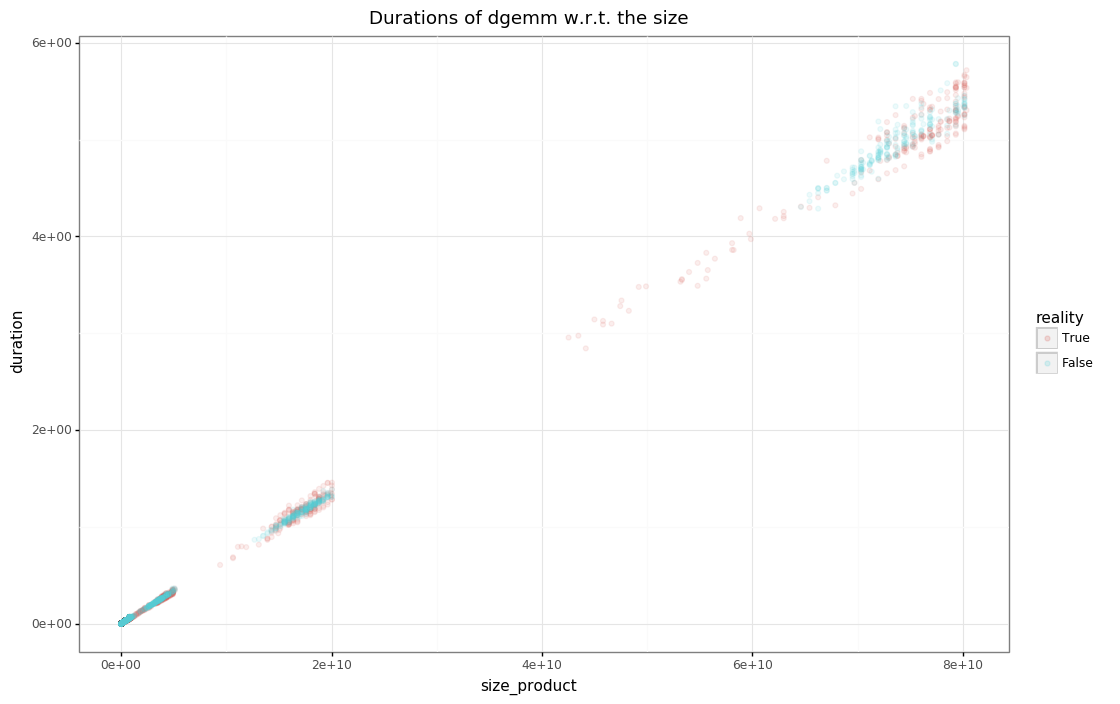

<ggplot: (-9223363242779019432)>


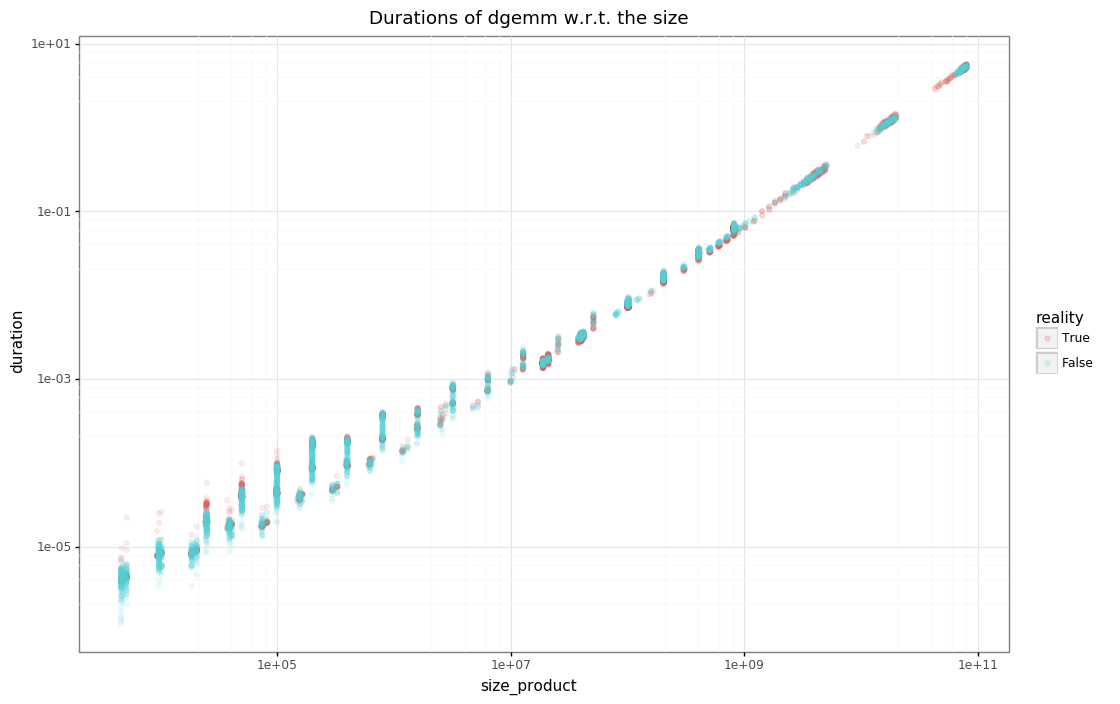

<ggplot: (8794076448397)>


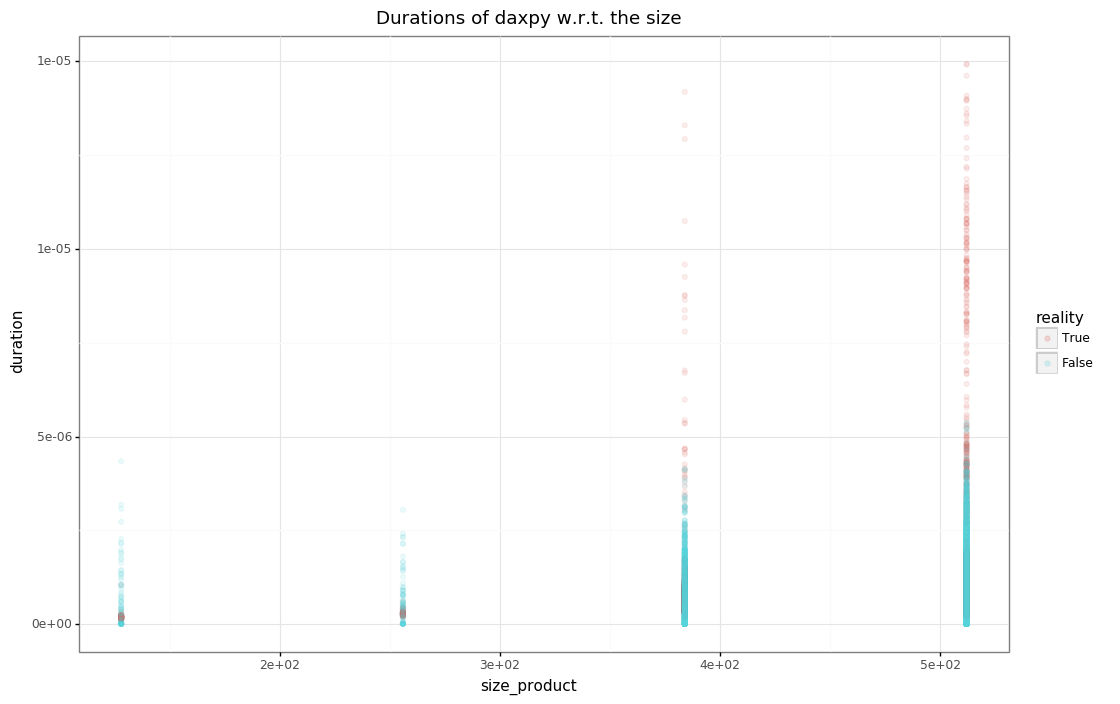

<ggplot: (8794075762240)>


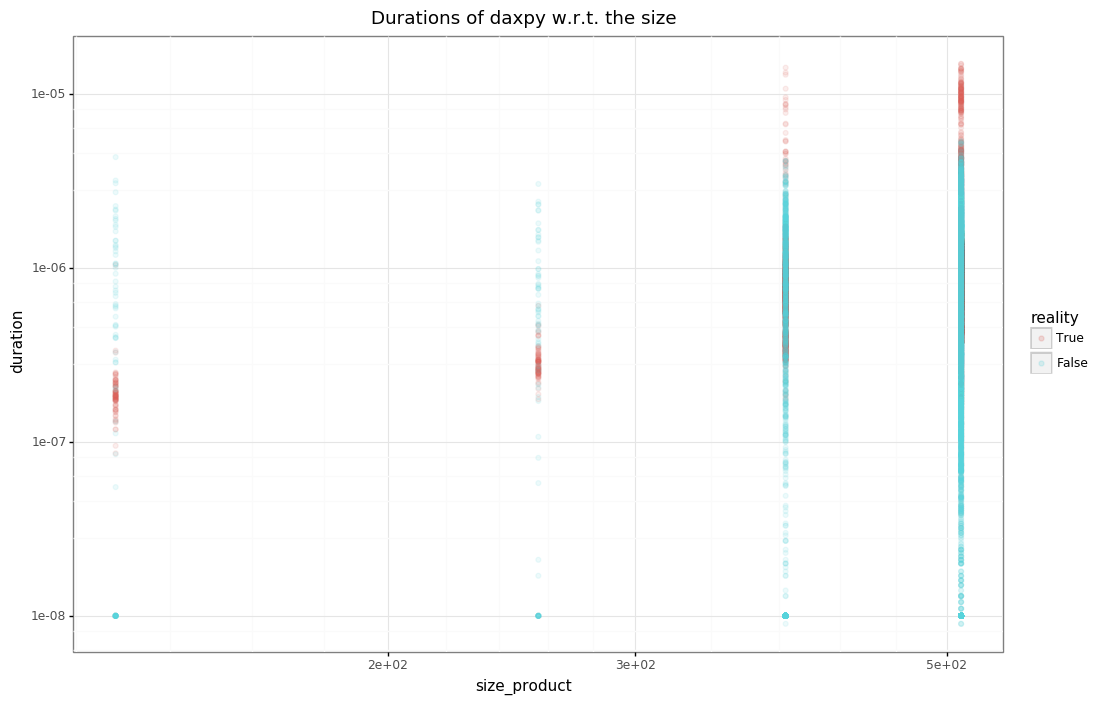

<ggplot: (8794074820556)>


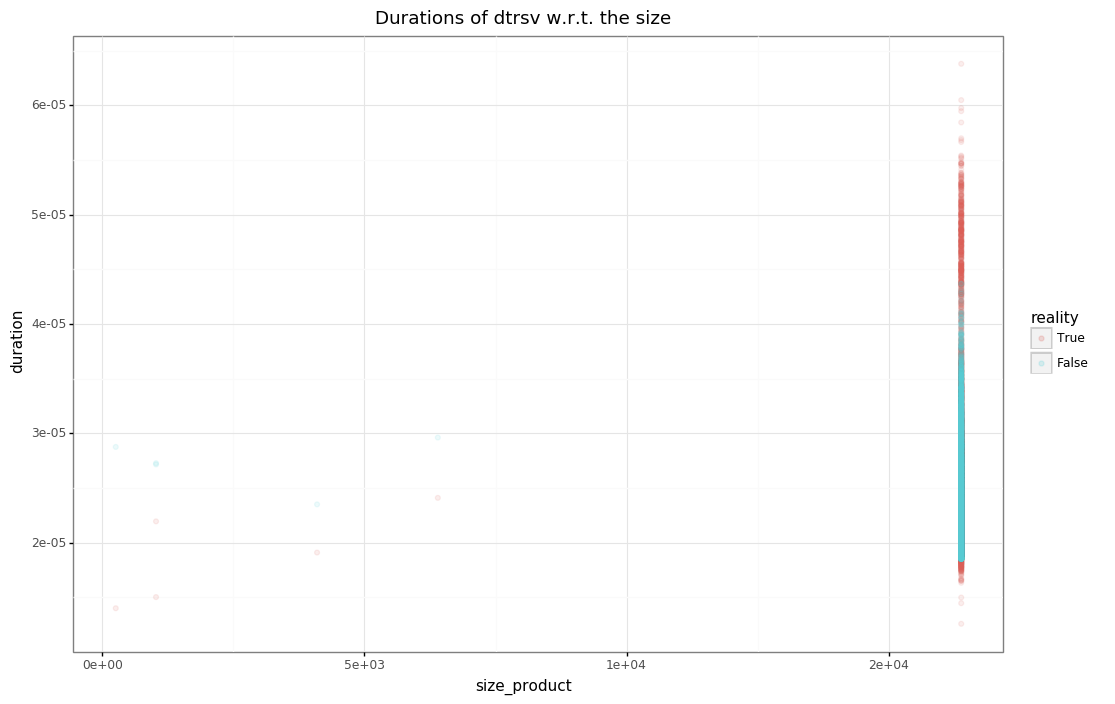

<ggplot: (8794104349339)>


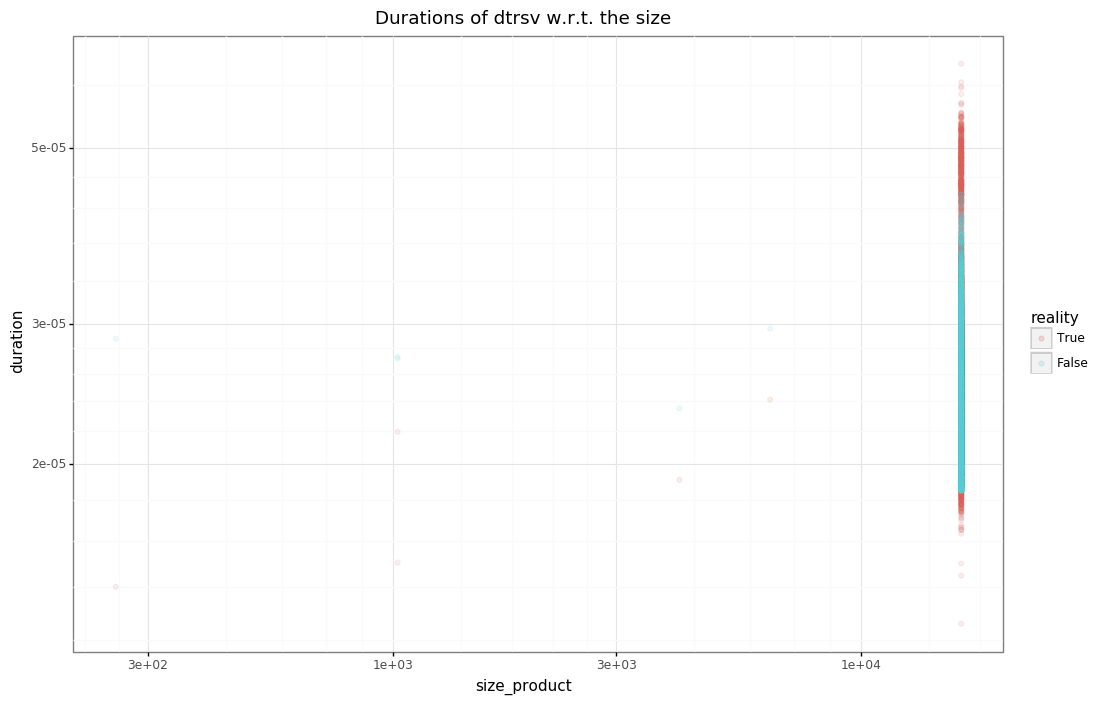

<ggplot: (-9223363242775722394)>


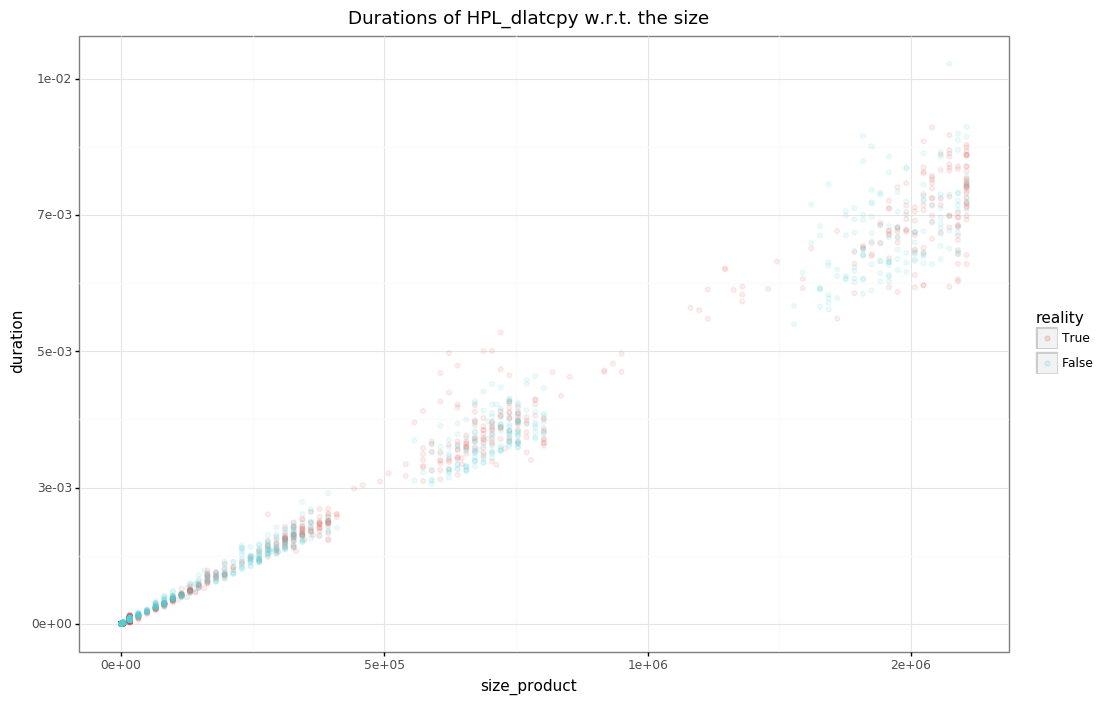

<ggplot: (8794075674558)>


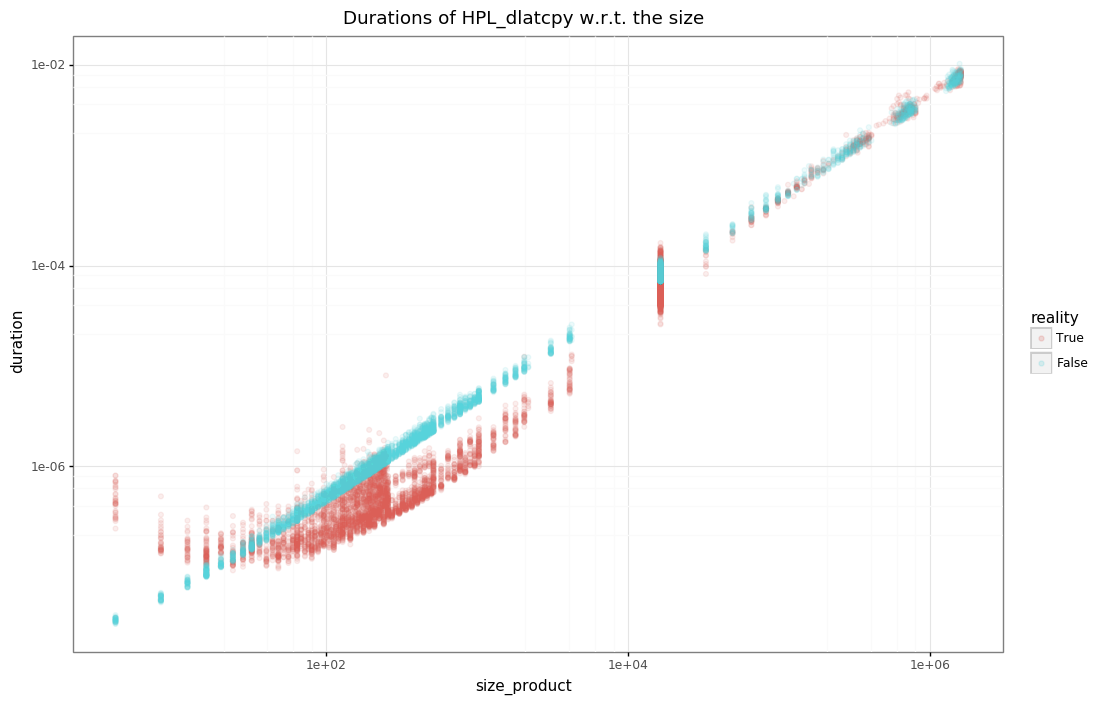

<ggplot: (-9223363242778747083)>


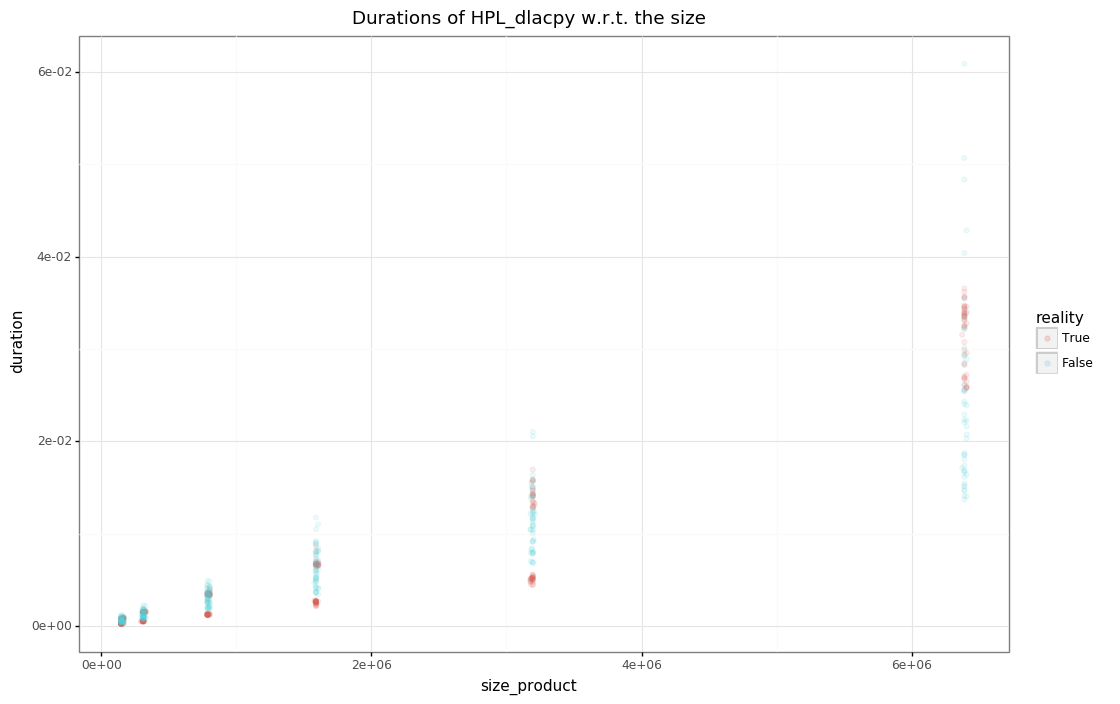

<ggplot: (-9223363242776762694)>


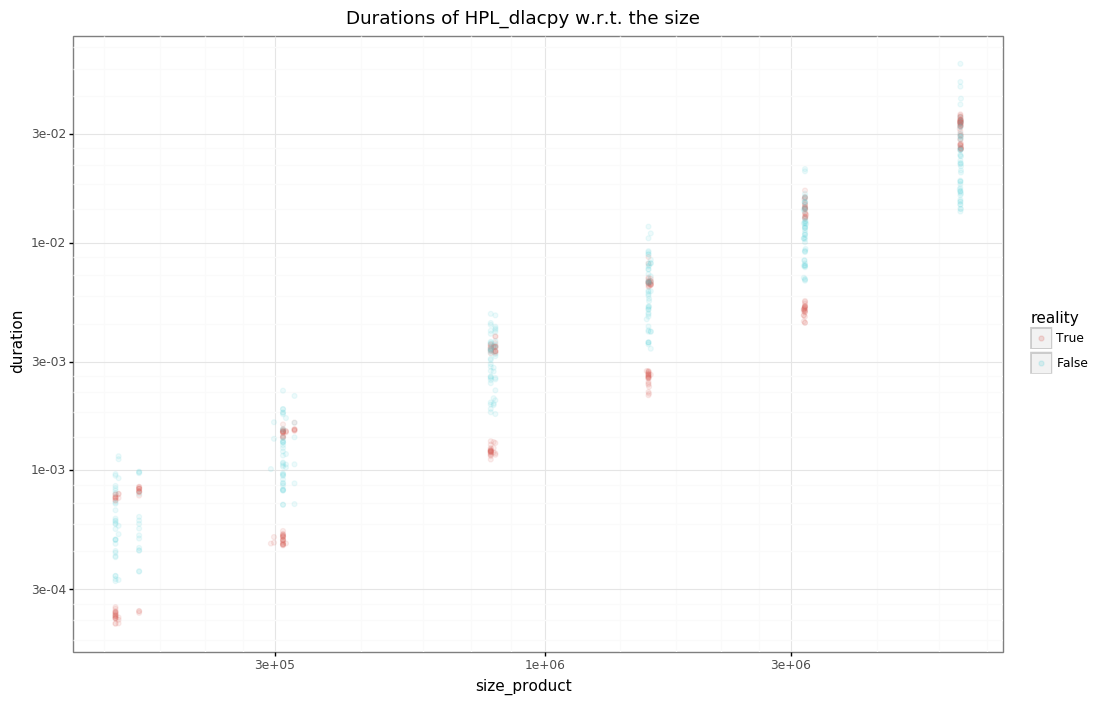

<ggplot: (8794075395192)>


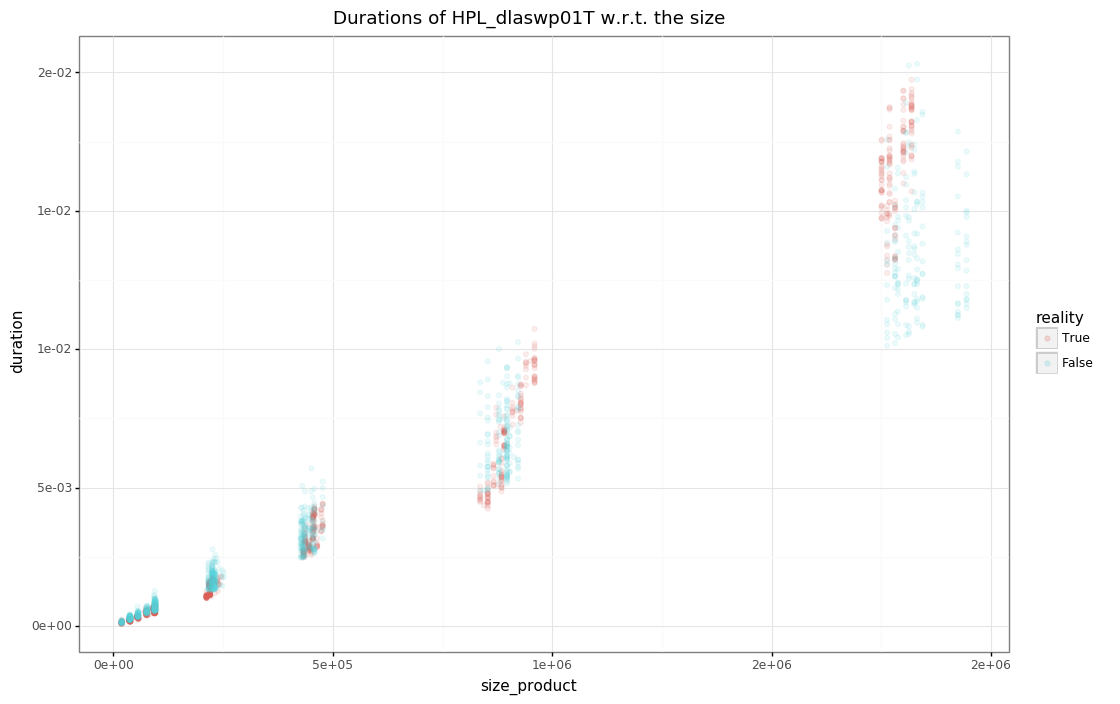

<ggplot: (-9223363242736344253)>


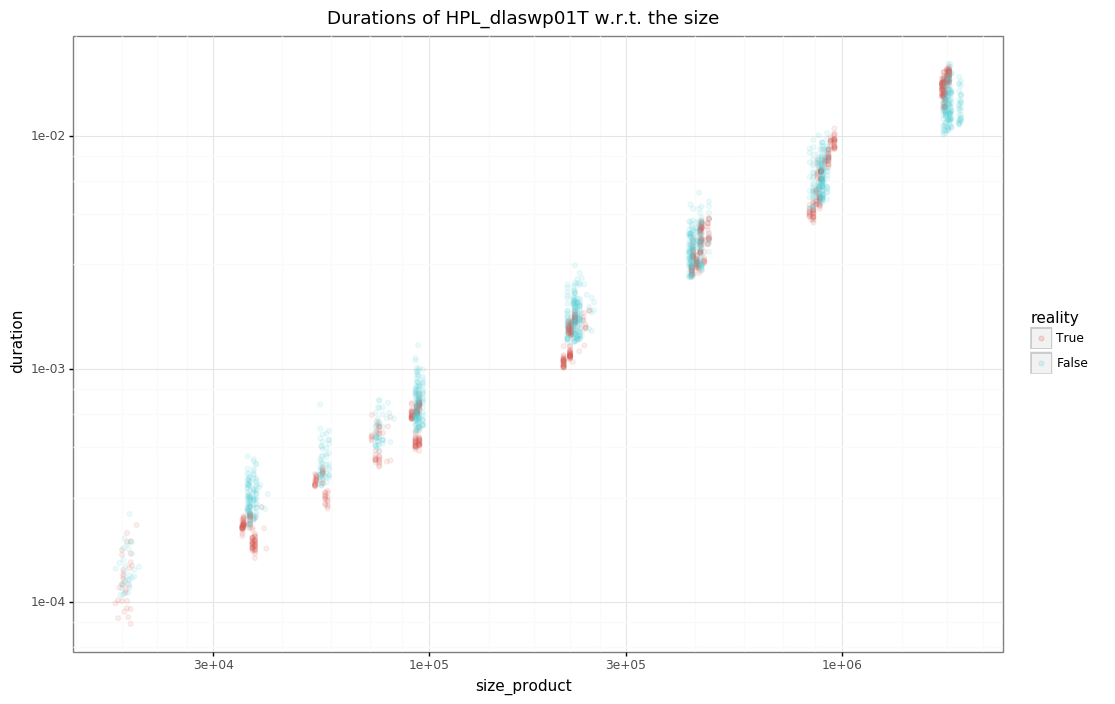

<ggplot: (-9223363242782219481)>


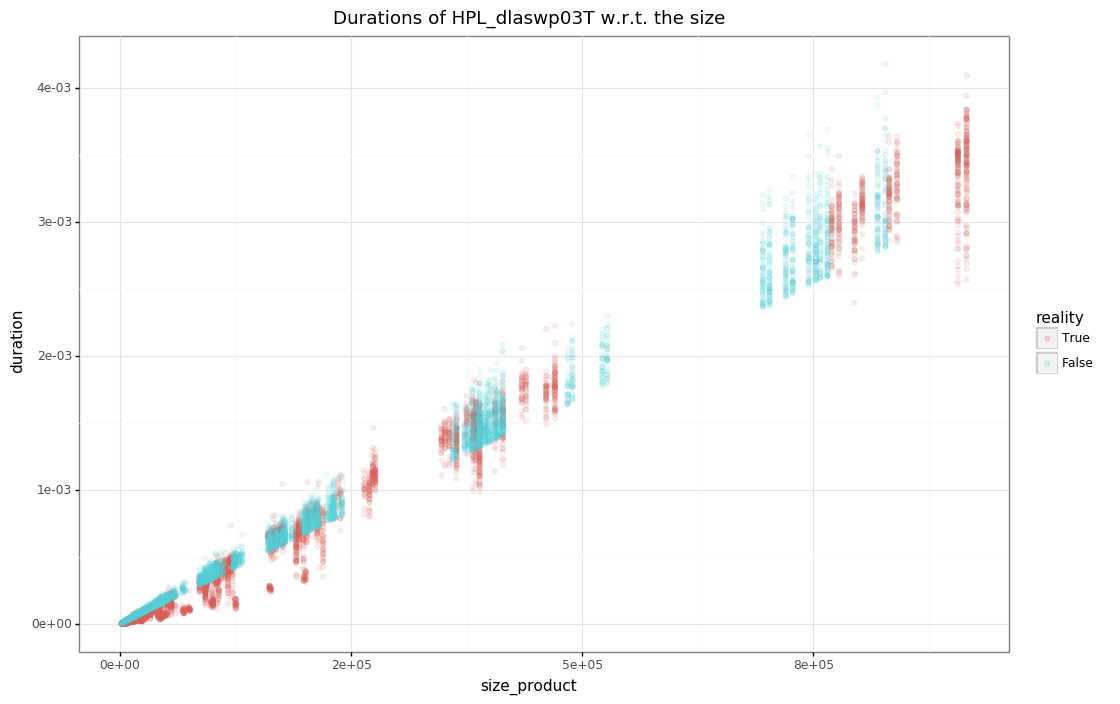

<ggplot: (8794075340278)>


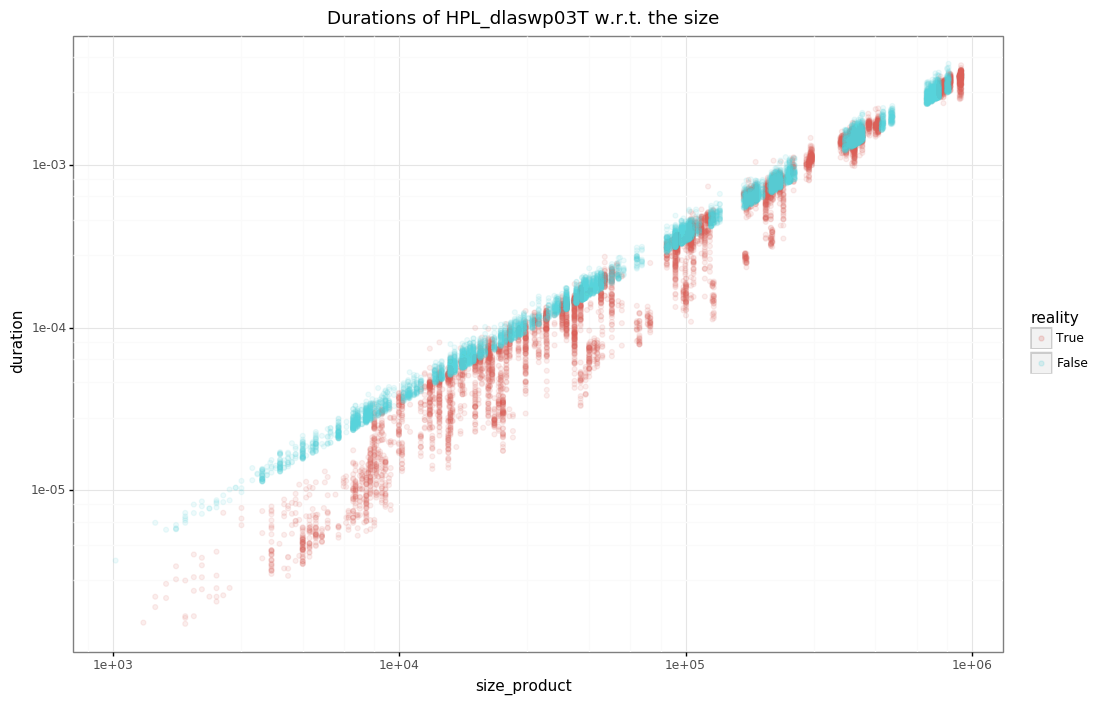

<ggplot: (8794075246831)>


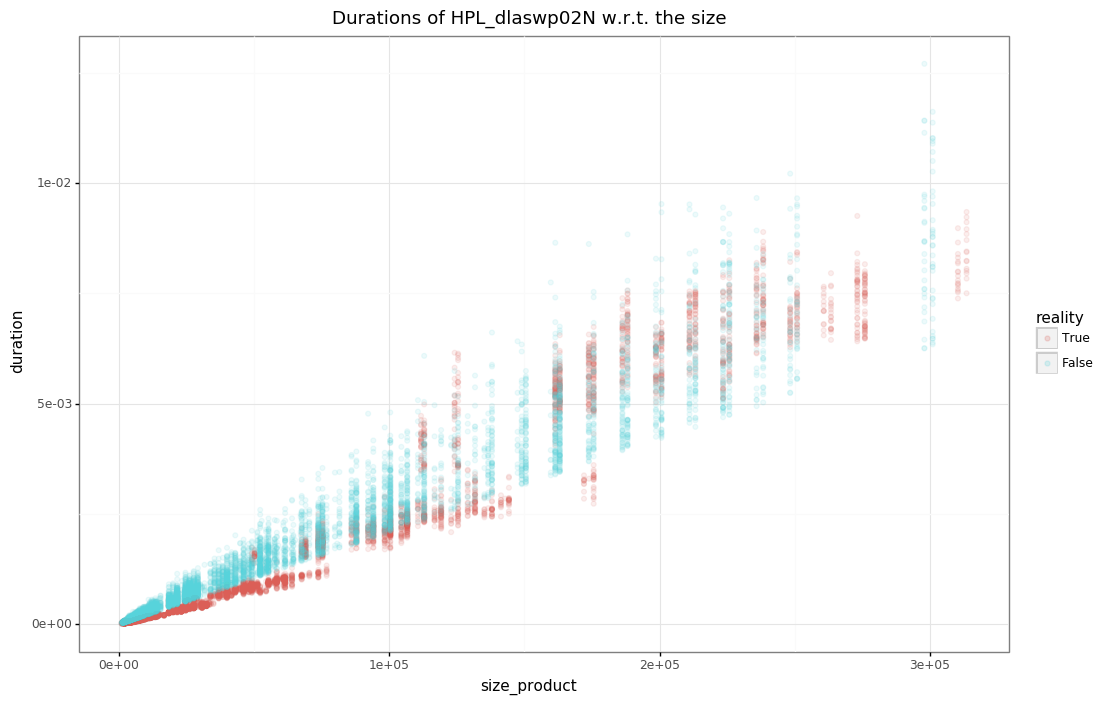

<ggplot: (-9223363242778555185)>


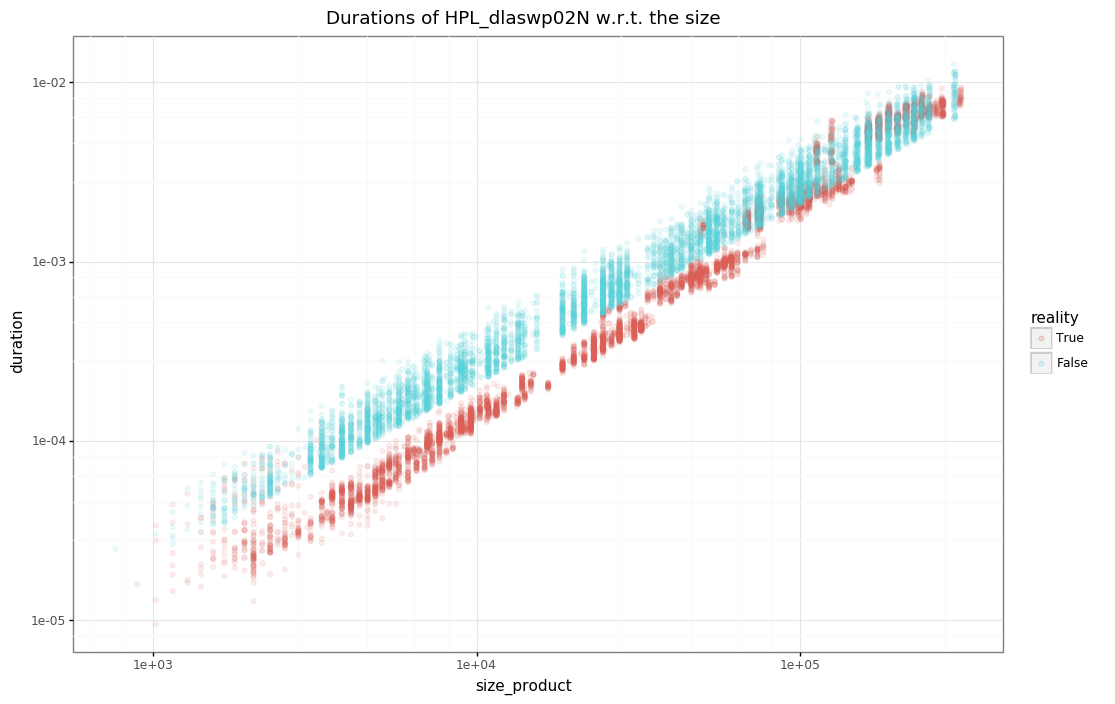

<ggplot: (-9223363242779527406)>


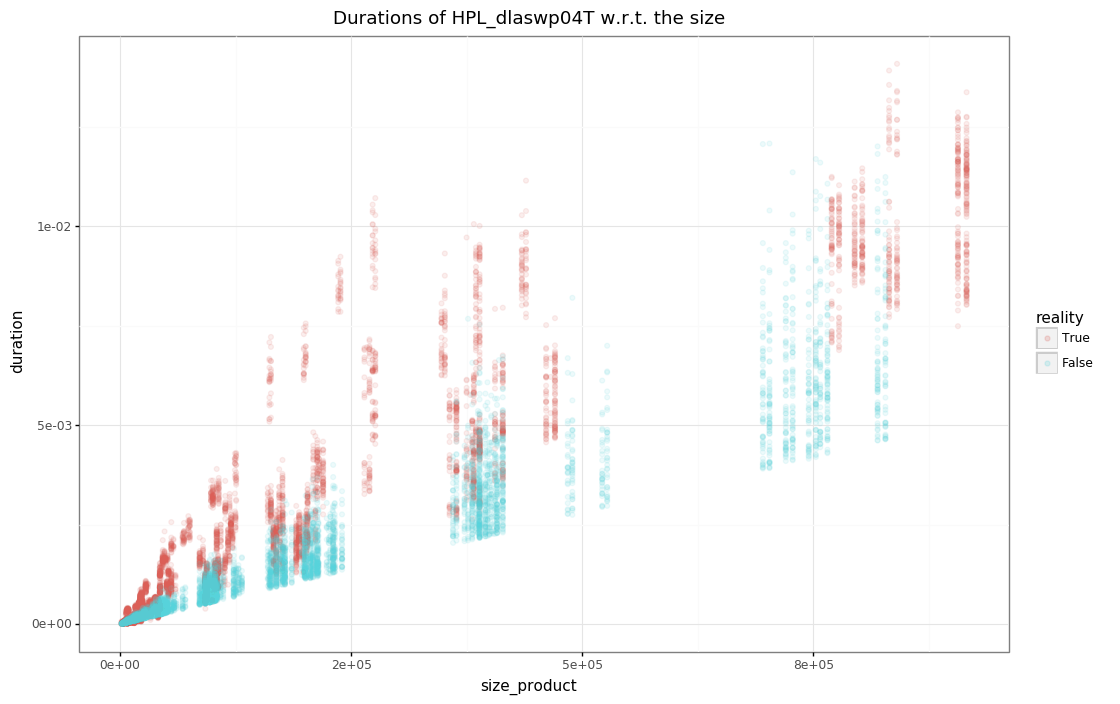

<ggplot: (8794075260406)>


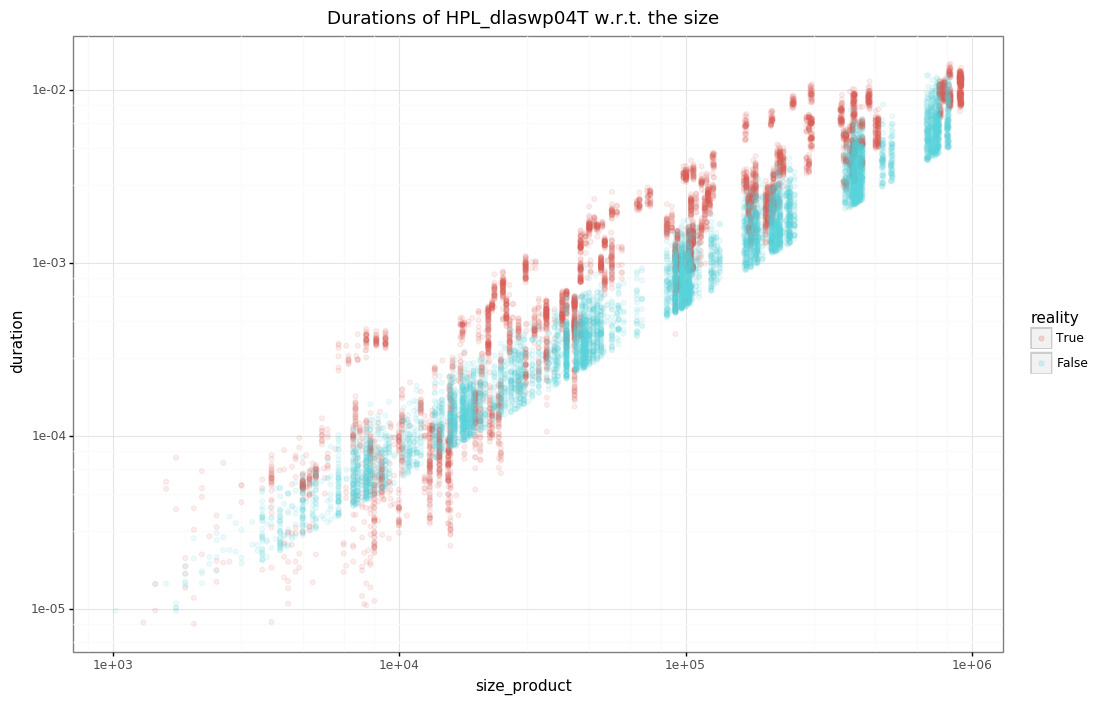

<ggplot: (8794077410687)>


In [24]:
def plot_size(df, n=10000):
    func = df.function.unique()[0]
    df = df.copy()
    df['reality'] = df['mode'] == 'reality'
    df_reality = df[df.reality][['reality', 'size_product', 'duration']]
    df_sim = df[~df.reality].copy()
    try:
        df_reality = df_reality.sample(n=n)
        df_sim = df_sim.sample(n=n)
    except ValueError:  # dataframe is too small
        pass
    my_label = lambda l: ['%.0e' % x for x in l]
    plot = ggplot(aes(x='size_product', y='duration', color='reality')) + geom_point(df_reality, alpha=0.1)
    plot = plot + geom_point(df_sim, alpha=0.1) + theme_bw() + ggtitle('Durations of %s w.r.t. the size' % func)
#    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25}) # the subplots_adjust is to fix a display bug...
    print(plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label))
    print(plot + scale_y_log10(labels=my_label) + scale_x_log10(labels=my_label))

for func in blas.function.unique():
    if not func.startswith('HPL_'):
        plot_size(blas[blas.function == func])
for func in blas.function.unique():
    if func.startswith('HPL_'):
        plot_size(blas[blas.function == func])

In [25]:
tmp = blas[blas.function.isin(['HPL_dlaswp02N', 'HPL_dlaswp03T', 'HPL_dlatcpy', 'dgemm', 'dtrsm'])][['function', 'm', 'n', 'k', 'start', 'end', 'duration', 'rank', 'mode']].copy()
tmp.loc[tmp['mode'] != 'reality', 'mode'] = 'simulation'
tmp.head()

function        m    n    k    start       end      duration  rank  \
11        dtrsm      2.0  2.0  NaN  0.01674  0.016784  4.433700e-05     0   
12        dgemm  50046.0  2.0  2.0  0.01678  0.016980  2.004260e-04     0   
24  HPL_dlatcpy      2.0  2.0  NaN  0.01726  0.017260  3.260000e-07     0   
25        dtrsm      4.0  4.0  NaN  0.01726  0.017261  1.438000e-06     0   
26        dgemm  50044.0  4.0  4.0  0.01727  0.017650  3.799440e-04     0   

       mode  
11  reality  
12  reality  
24  reality  
25  reality  
26  reality

In [26]:
tmp.to_csv('/tmp/trace_functions.csv', index=False)